# Import libraries & settings

In [1]:
import os

import pandas as pd

from bs4 import BeautifulSoup

import shutil

from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
# Settings
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)

In [3]:
# Path to root folder
dir_path = 'C:/Users/Adam/Documents/Out of the Park Developments/OOTP Baseball 24/saved_games/'

# Destination folder for processed game logs
destination_folder_pitchers = 'C:/Users/Adam/Desktop/OOTP/Pitchers_historical_logs'
destination_folder_batters = 'C:/Users/Adam/Desktop/OOTP/Batters_historical_logs'

# Destination folder for final data sets
destination_folder = 'C:/Users/Adam/Desktop/OOTP'

# Import and process logs

In [4]:
# Import HTML files
html_files = []

for root, dirs, files in os.walk(dir_path):
    if 'html' in dirs:
        temp_dir = os.path.join(root, 'html')
        if 'temp' in os.listdir(temp_dir):
            html_dir = os.path.join(temp_dir, 'temp')
            for file in os.listdir(html_dir):
                if file.endswith('.html'):
                    html_files.append(os.path.join(html_dir, file))


In [5]:
# Load the parquet "DBs" into a Pandas DataFrame
# https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
# feather was impossible to set up
df_pitchers = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters = pd.read_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

In [6]:
# ETL for new logs

for file in tqdm(html_files):
    # Reading the HTML file into a pandas DataFrame
    df = pd.read_html(file, flavor = 'bs4', skiprows=[0])[0]
    
    df = df.drop(0)
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    
    duplicate_cols = df.columns[df.columns.duplicated()]

    # Get a boolean mask indicating which column names are duplicates
    dupe_mask = df.columns.duplicated()

    # Add a suffix to duplicate column names
    df.columns = df.columns.where(~dupe_mask, df.columns + '_other')

    # Add column with timestamp (file name)
    # To be used to filter out old logs
    base_name = os.path.basename(file)
    file_name, file_extension = os.path.splitext(base_name)
    df['file_name'] = file_name
    
    # Concatenate the DataFrames for pitchers and batters independently
    if df.columns[6] == "STU":
        df_pitchers = pd.concat([df_pitchers, df])
        # Move
        shutil.move(file, destination_folder_pitchers)
    else:
        # Drop first column for batters
        df = df.drop(df.columns[0], axis=1)
        df_batters = pd.concat([df_batters, df])
        shutil.move(file, destination_folder_batters)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [19:44<00:00, 98.71s/it]


In [7]:
# Store unaggregated data between sessions in parquet file
df_pitchers.to_parquet(r'C:\Users\Adam\Desktop\OOTP\pitchers_db.parquet')
df_batters.to_parquet(r'C:\Users\Adam\Desktop\OOTP\batters_db.parquet')

# Prepare Dataframes

## Data Types

### Pitchers

In [8]:
pitchers_data_types = {
                "POS": str, "Name": str, "ORG": str, "B": str, "T": str, "OVR": int, "STU": int,
                "MOV": int, "CON": int, "PBABIP": int, "HRR": int, "STU vL": int, "MOV vL": int,
                "CON vL": int, "PBABIP vL": int, "HRR vL": int, "STU vR": int, "MOV vR": int,
                "CON vR": int, "PBABIP vR": int, "HRR vR": int, "FB": int, "CH": int, "CB": int,
                "SL": int, "SI": int, "SP": int, "CT": int, "FO": int, "CC": int, "SC": int,
                "KC": int, "KN": int, "PIT": int, "G/F": str, "VELO": str, "Slot": str, "PT": str,
                "STM": int, "HLD": int, "IF RNG": int, "IF ERR": int, "IF ARM": int, "P": int,
                "G": int, "GS": int, "W": int, "L": int, "WIN%": float, "SVO": int, "SV": int,
                "SV%": float, "BS": int, "BS%": float, "HLD_other": int, "SD": int, "MD": int,
                "IP": float, "BF": int, "AB": int, "HA": int, "1B": int, "2B": int, "3B": int,
                "HR": int, "TB": int, "R": int, "ER": int, "BB": int, "IBB": int, "K": int,
                "HP": int, "ERA": float, "AVG": float, "OBP": float, "SLG": float, "OPS": float,
                "BABIP": float, "WHIP": float, "RA/9": float, "HR/9": float, "H/9": float,
                "BB/9": float, "K/9": float, "K/BB": float, "K%": float, "BB%": float,
                "K%-BB%": float, "SH": int, "SF": int, "WP": int, "BK": int, "CI": int, "DP": int,
                "RA": int, "GF": int, "IR": int, "IRS": int, "IRS%": float, "LOB%": float,
                "pLi": float, "GF%": float, "QS": int, "QS%": float, "CG": int, "CG%": float,
                "SHO": int, "PPG": int, "RS": int, "RSG": float, "PI": int, "GB": int,
                "FB_other": int, "GO%": float, "SB": int, "CS": int, "ERA+": int, "FIP": float,
                "FIP-": float, "WPA": float, "WAR": float, "rWAR": float, "SIERA": float,
                "TC": int, "A": int, "PO": int, "E": int, "DP_other": int, "TP": int, "PCT": float,
                "RNG": float, "ZR": float, "EFF": float}

In [9]:
for col, dtype in pitchers_data_types.items():
    if df_pitchers[col].dtype != dtype and dtype != 'str':
        df_pitchers[col] = df_pitchers[col].replace('-', 0)
        #df_pitchers[col] = pd.to_numeric(df_pitchers[col], errors='coerce').astype(dtype)
        df_pitchers[col] = df_pitchers[col].astype(dtype, errors = 'ignore')
        

In [10]:
df_pitchers = df_pitchers.convert_dtypes().reset_index(drop=True)
df_pitchers['VELO'] = df_pitchers['VELO'].str.split('-').str[0]

In [11]:
# decimal format of innings pitched 
df_pitchers['IP'] = df_pitchers['IP'].apply(lambda x: int(x) + (x % 1 * 10) / 3)

### Batters

In [12]:
batters_data_types = {'POS': str, 'Name': str, 'ORG': str, 'Lev': str, 'HT': str, 'B': str, 'T': str, 'OVR': int, 
                'BABIP': int, 'CON': int, 'GAP': int, 'POW': int, 'EYE': int, 'K\'s': int, 'BABIP vL': int, 
                'CON vL': int, 'GAP vL': int, 'POW vL': int, 'EYE vL': int, 'K vL': int, 'BABIP vR': int, 
                'CON vR': int, 'GAP vR': int, 'POW vR': int, 'EYE vR': int, 'K vR': int, 'BUN': int, 'BFH': int, 
                'BBT': str, 'GBT': str, 'FBT': str, 'C ABI': int, 'C ARM': int, 'IF RNG': int, 'IF ERR': int, 
                'IF ARM': int, 'TDP': int, 'OF RNG': int, 'OF ERR': int, 'OF ARM': int, 'DEF': int, 'P': int, 
                'C': int, '1B': int, '2B': int, '3B': int, 'SS': int, 'LF': int, 'CF': int, 'RF': int, 'SPE': int, 
                'STE': int, 'RUN': int, 'G': int, 'GS': int, 'PA': int, 'AB': int, 'H': int, '1B_other': int, 
                '2B_other': int, '3B_other': int, 'HR': int, 'RBI': int, 'R': int, 'BB': int, 'BB%': float, 'IBB': int, 
                'HP': int, 'SH': int, 'SF': int, 'CI': int, 'SO': int, 'SO%': float, 'GIDP': int, 'EBH': int, 'TB': int, 
                'AVG': float, 'OBP': float, 'SLG': float, 'RC': float, 'RC/27': float, 'ISO': float, 'wOBA': float, 'OPS': float,  
                'OPS+': int, 'BABIP_other': float, 'WPA': float, 'wRC': int, 'wRC+': int, 'wRAA': float, 'WAR': float, 
                'PI/PA': float, 'SB': int, 'CS': int, 'SB%': float, 'BatR': float, 'wSB': float, 'UBR': float, 'BsR': float, 
                'G_other': int, 'GS_other': int, 'TC': int, 'A': int, 'PO': int, 'E': int, 'DP': int, 'TP': int, 
                'PCT': float, 'RNG': float, 'ZR': float, 'EFF': float, 'SBA': int, 'RTO': int, 'RTO%': float, 'IP': float, 
                'PB': int, 'CER': int, 'CERA': float, 'BIZ-R%': float, 'BIZ-R': int, 'BIZ-Rm': int, 'BIZ-L%': float, 
                'BIZ-L': int, 'BIZ-Lm': int, 'BIZ-E%': float, 'BIZ-E': int, 'BIZ-Em': int, 'BIZ-U%': float, 
                'BIZ-U': int, 'BIZ-Um': int, 'BIZ-Z%': float, 'BIZ-Z': int, 'BIZ-Zm': int, 'BIZ-I': int, 'FRM': float, 
                'ARM': float, 'BF%': float}


In [13]:
df_batters['GS'].fillna('0', inplace=True)
df_batters['G'].replace({None: '0'}, inplace=True)

In [14]:
for col, dtype in batters_data_types.items():
    if df_batters[col].dtype != dtype and dtype != 'str':
        df_batters[col] = df_batters[col].replace('-', 0)
        #df_batters[col] = pd.to_numeric(df_batters[col], errors='coerce').astype(dtype)
        if col in ['BIZ-R%', 'BIZ-L%', 'BIZ-E%', 'BIZ-U%', 'BIZ-Z%', 'BF%']:
            df_batters[col] = df_batters[col].str.replace('%', '')
        df_batters[col] = df_batters[col].astype(dtype, errors = 'ignore')

In [15]:
df_batters = df_batters.convert_dtypes().reset_index(drop=True)

## Aggregations

### Pitcher aggregations

Following method was too slow:

wm = lambda x: np.average(x, weights=df_pitchers.loc[x.index, 'IP']) if df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan

ip9 = lambda x: np.average(x * (9/df_pitchers.loc[x.index, 'IP']), weights=df_pitchers.loc[x.index, 'IP']) if 

df_pitchers.loc[x.index, 'IP'].sum() > 0 else np.nan

lambda_fncs = {col: ['sum', 'mean', wm, ip9] for col in df_pitchers.columns[53:]}

%%time

pitch_agg = df_pitchers_copy.agg(lambda_fncs)

In [16]:
wm_col = ["WIN%", "SV%", "BS%", "AVG", "OBP", "SLG", "OPS", "BABIP", "WHIP", "K/BB", "K%", "BB%", "K%-BB%", "IRS%", "LOB%", "pLi", "GF%", "QS%", "CG%", "PPG", "RS", "RSG", "PI", "GB", "FB_other", "GO%", "SB", "CS", "FIP", "FIP-", "SIERA", "PCT", "RNG", "ZR", "EFF"]

ip9_list = []

for item in df_pitchers[df_pitchers.iloc[:, 44:].columns]:
    if item not in wm_col:
            if (item != 'IP') & (item != 'file_name'):
                ip9_list.append(item)

In [17]:
# Aggregation per player and team
df_pitchers_agg_team = df_pitchers.drop(columns=['file_name']).copy()

df_pitchers_agg_team[wm_col] = df_pitchers_agg_team[wm_col].mul(df_pitchers_agg_team['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg_team = df_pitchers_agg_team.groupby(df_pitchers_agg_team.iloc[:, :44].columns.tolist()).sum()
df_pitchers_agg_team = df_pitchers_agg_team.reset_index()

# Save IP stats
df_pitchers_agg_team_IP = df_pitchers_agg_team['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg_team[df_pitchers_agg_team.iloc[:, 44:].columns] = df_pitchers_agg_team[df_pitchers_agg_team.columns[44:]].div(df_pitchers_agg_team['IP'], axis=0)
df_pitchers_agg_team[ip9_list] = df_pitchers_agg_team[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg_team = df_pitchers_agg_team.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg_team['IP'] = df_pitchers_agg_team_IP

In [18]:
# Aggregation per player
df_pitchers_agg = df_pitchers.copy()

df_pitchers_agg = df_pitchers_agg.drop(columns='ORG')

df_pitchers_agg[wm_col] = df_pitchers_agg[wm_col].mul(df_pitchers_agg['IP'], axis=0)

# Group by the ratings' columns and sum the values
df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()

df_pitchers_agg = df_pitchers_agg.reset_index()

# Save IP stats
df_pitchers_agg_IP = df_pitchers_agg['IP']

# Calculate statistics per 9 innings and update the corresponding columns
df_pitchers_agg[df_pitchers_agg.iloc[:, 43:].columns] = df_pitchers_agg[df_pitchers_agg.columns[43:]].div(df_pitchers_agg['IP'], axis=0)
df_pitchers_agg[ip9_list] = df_pitchers_agg[ip9_list].mul(9, axis=0)


# Drop columns that were already per 9 innings
df_pitchers_agg = df_pitchers_agg.drop(columns=['RA/9','HR/9','H/9','BB/9','K/9','ERA+'])

# Restore IP stats
df_pitchers_agg['IP'] = df_pitchers_agg_IP

C:\Users\Adam\AppData\Local\Temp\ipykernel_8372\2382736869.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pitchers_agg = df_pitchers_agg.groupby(df_pitchers_agg.iloc[:, :43].columns.tolist()).sum()


### Batter aggregations

In [19]:
pa600_list = ['G', 'GS','AB', 'H', '1B_other', '2B_other', '3B_other', 'HR', 'RBI', 'R', 'BB', 'IBB', 'HP', 'SH', 'SF', 'CI', 'SO', 'GIDP', 'EBH', 'TB', 'WPA', 'wRC', 'wRAA', 'WAR', 'SB', 'CS', 'BatR', 'wSB', 'UBR', 'BsR', 'G_other', 'GS_other', 'TC', 'A', 'PO', 'E', 'DP', 'TP', 'SBA', 'RTO']
wm_def_col = ['ZR', 'PCT','PB', 'CER', 'BIZ-R', 'BIZ-Rm', 'BIZ-L', 'BIZ-Lm', 'BIZ-E', 'BIZ-Em', 'BIZ-U', 'BIZ-Um', 'BIZ-Z', 'BIZ-Zm', 'BIZ-I', 'FRM', 'ARM']

wm_col = []

for item in df_batters[df_batters.iloc[:, 53:].columns]:
    if item not in pa600_list:
        if item not in wm_def_col:
            if (item != 'file_name'):
                wm_col.append(item)


In [20]:
# Aggregation per player and team
df_batters_agg_team = df_batters.drop(columns=['file_name']).copy()

df_batters_agg_team['PA_WM'] = df_batters_agg_team['PA']
df_batters_agg_team['IP_WM'] = df_batters_agg_team['IP']
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].mul(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].mul(df_batters_agg_team['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg_team = df_batters_agg_team.groupby(df_batters_agg_team.iloc[:, :53].columns.tolist()).sum()

# Reset index
df_batters_agg_team = df_batters_agg_team.reset_index()

# Calculate statistics per 600 PAs (and 9 inning) and update the corresponding columns
df_batters_agg_team[wm_col] = df_batters_agg_team[wm_col].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA_WM'], axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP_WM'], axis=0)
df_batters_agg_team[pa600_list] = df_batters_agg_team[pa600_list].div(df_batters_agg_team['PA'], axis=0).mul(600, axis=0)
df_batters_agg_team[wm_def_col] = df_batters_agg_team[wm_def_col].div(df_batters_agg_team['IP'], axis=0).mul(9, axis=0)

In [21]:
# Aggregation per player
df_batters_agg = df_batters.copy()

df_batters_agg = df_batters_agg.drop(columns='ORG')

df_batters_agg['PA_WM'] = df_batters_agg['PA']
df_batters_agg['IP_WM'] = df_batters_agg['IP']
df_batters_agg[wm_col] = df_batters_agg[wm_col].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].mul(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].mul(df_batters_agg['IP_WM'], axis=0)

# Group by the ratings' columns and sum the values
df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()
df_batters_agg = df_batters_agg.reset_index()

# Calculate statistics per 600 PAs and update the corresponding columns
df_batters_agg[wm_col] = df_batters_agg[wm_col].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA_WM'], axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP_WM'], axis=0)
df_batters_agg[pa600_list] = df_batters_agg[pa600_list].div(df_batters_agg['PA'], axis=0).mul(600, axis=0)
df_batters_agg[wm_def_col] = df_batters_agg[wm_def_col].div(df_batters_agg['IP'], axis=0).mul(9, axis=0)

C:\Users\Adam\AppData\Local\Temp\ipykernel_8372\2609498799.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_batters_agg = df_batters_agg.groupby(df_batters_agg.iloc[:, :52].columns.tolist()).sum()


### Team aggregations

In [22]:
# preparation of position columns for weighted average
df_batters['AVG_C'] = (np.where(df_batters['POS'] == 'C', df_batters['C'], 0) * np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_C'] = np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['IP'], 0).astype(int)
df_batters['FRM_C'] = (np.where(df_batters['POS'] == 'C', df_batters['FRM'], 0) * np.where((df_batters['POS'] == 'C') & (df_batters['C'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['1B'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_1B'] = np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['ZR'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_1B'] = (np.where(df_batters['POS'] == '1B', df_batters['PCT'], 0) * np.where((df_batters['POS'] == '1B') & (df_batters['1B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['2B'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_2B'] = np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['ZR'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_2B'] = (np.where(df_batters['POS'] == '2B', df_batters['PCT'], 0) * np.where((df_batters['POS'] == '2B') & (df_batters['2B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['3B'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_3B'] = np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['ZR'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_3B'] = (np.where(df_batters['POS'] == '3B', df_batters['PCT'], 0) * np.where((df_batters['POS'] == '3B') & (df_batters['3B'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['SS'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_SS'] = np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_SS'] = (np.where(df_batters['POS'] == 'SS', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'SS') & (df_batters['SS'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['LF'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_LF'] = np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_LF'] = (np.where(df_batters['POS'] == 'LF', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'LF') & (df_batters['LF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['CF'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_CF'] = np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_CF'] = (np.where(df_batters['POS'] == 'CF', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'CF') & (df_batters['CF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['RF'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['IP_RF'] = np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0).astype(int)
df_batters['ZR_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['ZR'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['PCT_RF'] = (np.where(df_batters['POS'] == 'RF', df_batters['PCT'], 0) * np.where((df_batters['POS'] == 'RF') & (df_batters['RF'] > 0), df_batters['IP'], 0)).astype(int)
df_batters['AVG_BABIP'] = df_batters['BABIP'] * df_batters['PA']
df_batters['AVG_GAP'] = df_batters['GAP'] * df_batters['PA']
df_batters['AVG_POW'] = df_batters['POW'] * df_batters['PA']
df_batters['AVG_EYE'] = df_batters['EYE'] * df_batters['PA']
df_batters['AVG_KS'] = df_batters["K's"] * df_batters['PA']

In [23]:
# aggregation
df_team_agg_temp = df_batters.groupby('ORG')[['1B_other','2B_other','HR', 'R', 'BB','SB','AVG_C', 'IP_C', 'FRM_C','AVG_1B', 'IP_1B', 'ZR_1B', 'PCT_1B','AVG_2B', 'IP_2B','ZR_2B','PCT_2B','AVG_3B', 'IP_3B','ZR_3B','PCT_3B','AVG_SS', 'IP_SS','ZR_SS','PCT_SS','AVG_LF', 'IP_LF','ZR_LF','PCT_LF','AVG_CF', 'IP_CF','ZR_CF','PCT_CF','AVG_RF', 'IP_RF','ZR_RF','PCT_RF','IP', 'PA','AVG_BABIP','AVG_GAP','AVG_POW','AVG_EYE','AVG_KS']].sum().reset_index()
df_team_agg_temp = df_team_agg_temp.rename(columns={'1B_other':'SINGLE','2B_other':'DOUBLE'})

In [24]:
# w. averages
df_team_agg_temp['AVG_C'] = df_team_agg_temp['AVG_C']/df_team_agg_temp['IP_C']
df_team_agg_temp['AVG_1B'] = df_team_agg_temp['AVG_1B']/df_team_agg_temp['IP_1B']
df_team_agg_temp['AVG_2B'] = df_team_agg_temp['AVG_2B']/df_team_agg_temp['IP_2B']
df_team_agg_temp['AVG_3B'] = df_team_agg_temp['AVG_3B']/df_team_agg_temp['IP_3B']
df_team_agg_temp['AVG_SS'] = df_team_agg_temp['AVG_SS']/df_team_agg_temp['IP_SS']
df_team_agg_temp['AVG_LF'] = df_team_agg_temp['AVG_LF']/df_team_agg_temp['IP_LF']
df_team_agg_temp['AVG_CF'] = df_team_agg_temp['AVG_CF']/df_team_agg_temp['IP_CF']
df_team_agg_temp['AVG_RF'] = df_team_agg_temp['AVG_RF']/df_team_agg_temp['IP_RF']

df_team_agg_temp['FRM_C'] = df_team_agg_temp['FRM_C']/df_team_agg_temp['IP_C']
df_team_agg_temp['ZR_1B'] = df_team_agg_temp['ZR_1B']/df_team_agg_temp['IP_1B']
df_team_agg_temp['ZR_2B'] = df_team_agg_temp['ZR_2B']/df_team_agg_temp['IP_2B']
df_team_agg_temp['ZR_3B'] = df_team_agg_temp['ZR_3B']/df_team_agg_temp['IP_3B']
df_team_agg_temp['ZR_SS'] = df_team_agg_temp['ZR_SS']/df_team_agg_temp['IP_SS']
df_team_agg_temp['ZR_LF'] = df_team_agg_temp['ZR_LF']/df_team_agg_temp['IP_LF']
df_team_agg_temp['ZR_CF'] = df_team_agg_temp['ZR_CF']/df_team_agg_temp['IP_CF']
df_team_agg_temp['ZR_RF'] = df_team_agg_temp['ZR_RF']/df_team_agg_temp['IP_RF']

df_team_agg_temp['PCT_1B'] = df_team_agg_temp['PCT_1B']/df_team_agg_temp['IP_1B']
df_team_agg_temp['PCT_2B'] = df_team_agg_temp['PCT_2B']/df_team_agg_temp['IP_2B']
df_team_agg_temp['PCT_3B'] = df_team_agg_temp['PCT_3B']/df_team_agg_temp['IP_3B']
df_team_agg_temp['PCT_SS'] = df_team_agg_temp['PCT_SS']/df_team_agg_temp['IP_SS']
df_team_agg_temp['PCT_LF'] = df_team_agg_temp['PCT_LF']/df_team_agg_temp['IP_LF']
df_team_agg_temp['PCT_CF'] = df_team_agg_temp['PCT_CF']/df_team_agg_temp['IP_CF']
df_team_agg_temp['PCT_RF'] = df_team_agg_temp['PCT_RF']/df_team_agg_temp['IP_RF']

df_team_agg_temp['AVG_BABIP'] = df_team_agg_temp['AVG_BABIP']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_GAP'] = df_team_agg_temp['AVG_GAP']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_POW'] = df_team_agg_temp['AVG_POW']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_EYE'] = df_team_agg_temp['AVG_EYE']/df_team_agg_temp['PA']
df_team_agg_temp['AVG_KS'] = df_team_agg_temp["AVG_KS"]/df_team_agg_temp['PA']

In [25]:
df_pitchers['AVG_STU'] = df_pitchers['STU'] * df_pitchers['IP']
df_pitchers['AVG_CON'] = df_pitchers['CON'] * df_pitchers['IP']
df_pitchers['AVG_PBABIP'] = df_pitchers['PBABIP'] * df_pitchers['IP']
df_pitchers['AVG_HRR'] = df_pitchers['HRR'] * df_pitchers['IP']

In [26]:
# Aggregate pitchers' data by team
df_team_agg = df_pitchers.groupby('ORG')[['IP','W','L','HR','R', 'ER', 'BB', 'K','AVG_STU','AVG_CON','AVG_PBABIP','AVG_HRR']].sum().copy()
df_team_agg = df_team_agg.rename(columns={'IP':'IPP','HR': 'HRA', 'R': 'RA', 'ER': 'ERA', 'BB': 'BBA','K':'KA'})

# Merge with batters' data by team
df_team_agg = df_team_agg.merge(df_team_agg_temp, on='ORG', how='left')

df_team_agg['AVG_STU'] = df_team_agg['AVG_STU'] / df_team_agg['IPP']
df_team_agg['AVG_CON'] = df_team_agg['AVG_CON'] / df_team_agg['IPP']
df_team_agg['AVG_PBABIP'] = df_team_agg['AVG_PBABIP'] / df_team_agg['IPP']
df_team_agg['AVG_HRR'] = df_team_agg['AVG_HRR'] / df_team_agg['IPP']


# Adding averages per game
for metric in df_team_agg.iloc[:, list(range(2,9)) + list(range(13,19))].columns:
    name = 'AVG_'+metric
    df_team_agg[name] = df_team_agg[metric] / (df_team_agg['W'] + df_team_agg['L'])
    df_team_agg[name] = df_team_agg[name]
    
    # Handling missings 
    df_team_agg[name].fillna(0, inplace=True)
    df_team_agg[name].replace({None: 0}, inplace=True)

# Filter teams with more than X wins, and sort by winning rate
df_team_agg[df_team_agg['W'] > 50].sort_values('AVG_W', ascending=False)

,ORG,IPP,W,L,HRA,RA,ERA,BBA,KA,AVG_STU,AVG_CON,AVG_PBABIP,AVG_HRR,SINGLE,DOUBLE,HR,R,BB,SB,AVG_C,IP_C,FRM_C,AVG_1B,IP_1B,ZR_1B,PCT_1B,AVG_2B,IP_2B,ZR_2B,PCT_2B,AVG_3B,IP_3B,ZR_3B,PCT_3B,AVG_SS,IP_SS,ZR_SS,PCT_SS,AVG_LF,IP_LF,ZR_LF,PCT_LF,AVG_CF,IP_CF,ZR_CF,PCT_CF,AVG_RF,IP_RF,ZR_RF,PCT_RF,IP,PA,AVG_BABIP,AVG_GAP,AVG_POW,AVG_EYE,AVG_KS,AVG_W,AVG_L,AVG_HRA,AVG_RA,AVG_ERA,AVG_BBA,AVG_KA,AVG_SINGLE,AVG_DOUBLE,AVG_HR,AVG_R,AVG_BB,AVG_SB
312,Quito Mosquitos,1093.666667,78,42,146,516,487,419,817,66.377934,72.1847,91.469064,70.867723,771,238,183,706,501,0,109.430530,1094,1.172761,65.107735,1086,0.079190,0.994475,79.794702,755,0.688742,0.980132,84.213523,1686,0.521352,0.960854,117.025275,910,2.757143,0.984615,90.018828,956,0.587866,0.986402,109.377702,879,1.646189,0.980660,96.322182,1375,0.989818,0.976727,8743.5,4848,67.609942,67.194513,54.380569,75.22401,56.18255,0.65,0.35,1.216667,4.3,4.058333,3.491667,6.808333,6.425,1.983333,1.525,5.883333,4.175,0.0
48,Biggleswade Bombers,798.333333,56,33,116,398,380,332,727,75.408768,69.255115,87.939875,75.935282,522,182,139,518,361,48,109.458647,798,0.487469,60.640205,781,0.037132,0.994878,69.074431,1142,0.047285,0.985114,69.012371,485,0.449485,0.969072,93.546028,793,-0.081967,0.963430,99.028129,711,0.566807,0.985935,84.533421,763,-0.442988,0.981651,90.361142,911,0.805708,0.991218,6384.8,3515,69.328592,75.55192,66.393741,70.968421,53.81707,0.629213,0.370787,1.303371,4.47191,4.269663,3.730337,8.168539,5.865169,2.044944,1.561798,5.820225,4.05618,0.539326
4,Albuquerque Albatross,902.333333,62,38,120,435,420,333,666,66.5471,73.570004,85.665682,72.441818,611,203,143,549,427,30,109.575358,909,0.702970,70.129213,890,0.210112,0.991011,73.489574,1103,0.185857,0.988214,84.024390,861,1.576074,0.976771,91.000000,765,0.833987,0.984314,85.408360,933,0.275456,0.988210,NaN,0,NaN,NaN,64.591748,921,0.300760,0.975027,7216.6,3984,62.408886,70.353414,65.953062,79.73996,55.647841,0.62,0.38,1.2,4.35,4.2,3.33,6.66,6.11,2.03,1.43,5.49,4.27,0.3
155,Fogtown Stars,8380.666667,560,372,934,4261,4020,3294,6993,67.058229,71.995704,64.311749,86.271896,5774,1785,1319,5196,3840,386,101.306178,8433,0.326337,69.518241,8141,-0.136470,0.990665,70.819959,12836,0.097382,0.980056,65.086237,6772,0.595983,0.962640,117.044608,7353,1.647491,0.981368,81.885597,6582,-0.069736,0.984959,86.052959,7081,-0.511368,0.982912,69.468718,9814,-0.025168,0.983697,67279.1,36999,68.806995,71.697776,59.934377,76.988946,63.296413,0.600858,0.399142,1.002146,4.571888,4.313305,3.534335,7.503219,6.195279,1.915236,1.415236,5.575107,4.120172,0.414163
311,Puyallup Fair - HotL,1303.000000,87,59,198,657,637,516,1118,71.786902,70.05142,88.876695,72.879765,957,313,169,776,532,62,108.168413,1336,0.454341,66.305469,1280,0.215625,0.995313,90.870771,1478,1.045332,0.989175,71.652756,1270,0.908661,0.959843,115.888689,1114,1.673250,0.982047,98.733042,1371,0.340627,0.987600,75.567371,1514,0.399604,0.984148,71.046980,1043,-1.179291,0.979866,10411.4,5753,69.763775,77.569268,52.809491,70.094907,67.062576,0.59589,0.40411,1.356164,4.5,4.363014,3.534247,7.657534,6.554795,2.143836,1.157534,5.315068,3.643836,0.424658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Casper Blue Hens,1042.000000,56,59,164,620,581,498,888,67.973448,63.977607,88.088932,64.858605,685,216,139,581,475,114,99.872881,1062,0.042373,84.316732,1285,-0.003113,0.992218,73.046771,898,-0.526726,0.973274,59.886747,1245,0.097189,0.959036,91.010227,880,-0.005682,0.965909,82.488404,733,-0.062756,0.989086,113.060573,908,0.088106,0.973568,61.661574,1309,-0.165775,0.956455,8324.8,4548,62.37533,65.842348,57.28496,75.245383,54.89248,0.486957,0.513043,1.426087,5.391304,5.052174,4.330435,7.721739,5.956522,1.878261,1.208696,5.052174,4.130435,0.991304
12,Arm Chair Rocket Scientists,1034.000000,55,5

In [27]:
# fillnas # wouldn't be better to drop NAs?
df_team_agg['AVG_C'].fillna(50, inplace=True)
df_team_agg['AVG_1B'].fillna(50, inplace=True)
df_team_agg['AVG_2B'].fillna(50, inplace=True)
df_team_agg['AVG_3B'].fillna(50, inplace=True)
df_team_agg['AVG_SS'].fillna(50, inplace=True)
df_team_agg['AVG_LF'].fillna(50, inplace=True)
df_team_agg['AVG_CF'].fillna(50, inplace=True)
df_team_agg['AVG_RF'].fillna(50, inplace=True)

df_team_agg['AVG_C'].replace({None: 50}, inplace=True)
df_team_agg['AVG_1B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_2B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_3B'].replace({None: 50}, inplace=True)
df_team_agg['AVG_SS'].replace({None: 50}, inplace=True)
df_team_agg['AVG_LF'].replace({None: 50}, inplace=True)
df_team_agg['AVG_CF'].replace({None: 50}, inplace=True)
df_team_agg['AVG_RF'].replace({None: 50}, inplace=True)



df_team_agg['AVG_BABIP'].fillna(50, inplace=True)
df_team_agg['AVG_GAP'].fillna(50, inplace=True)
df_team_agg['AVG_POW'].fillna(50, inplace=True)
df_team_agg['AVG_EYE'].fillna(50, inplace=True)
df_team_agg['AVG_KS'].fillna(50, inplace=True)

df_team_agg['AVG_BABIP'].replace({None: 50}, inplace=True)
df_team_agg['AVG_GAP'].replace({None: 50}, inplace=True)
df_team_agg['AVG_POW'].replace({None: 50}, inplace=True)
df_team_agg['AVG_EYE'].replace({None: 50}, inplace=True)
df_team_agg['AVG_KS'].replace({None: 50}, inplace=True)

# Analysis

## Target team comparison

The primary focus is to assess the contribution of each baseball position on the team and identify any weak spots or players who are under-performing.

### Batting

In [108]:
pd.set_option('display.max_rows', 50)
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (df_batters_agg_team['PA_WM'] > 100)].sort_values('OPS', ascending=False)

,POS,Name,ORG,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,BBT,GBT,FBT,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM
4101,DH,Andre Ethier,Fogtown Stars,TRN,"6' 2""",Left,Left,64,83,93,87,79,63,65,67,61,61,56,45,44,89,103,96,87,68,72,5,3,Line Drive,Pull,Spray,0,0,3,7,5,5,46,54,76,0,0,0,0,0,0,0,57,0,52,38,41,55,179.800175,136.652441,56.089485,528.176851,163.132179,89.316768,37.266672,3.21873,33.33001,102.299378,98.560147,65.912173,11.130593,1.735003,1.501675,0.0,4.044352,0.364949,98.506302,16.880425,18.313258,73.815412,306.82634,0.306922,0.383291,0.585694,10.970973,8.814318,0.278701,0.410609,0.968989,145.271253,0.320595,2.686981,105.727505,146.849553,35.302529,3.860681,3.743003,0.352983,2.237556,3.299776,35.302529,-0.412213,-0.987157,-1.396378,25.96522,7.083599,18.157706,0.436742,17.266273,0.45469,0.0,0.0,1.079736,1.659883,-0.108131,0.584142,0.0,0.0,0.0,7.498378,0.0,0.0,0.0,52.824385,3.15113,3.058842,13.870246,0.702929,0.369666,3.747204,0.589619,0.128178,3.747204,0.312755,0.020508,2.12528,0.467081,0.10767,1.175137,0.0,0.049887,100.0,1788,234.1
682,1B,Lou Gehrig,Fogtown Stars,TRN,"6' 0""",Left,Left,65,62,70,71,84,99,45,64,58,64,61,69,39,61,74,73,92,109,47,49,38,Flyball,Pull,Normal,0,0,35,35,35,38,7,1,3,55,0,0,55,0,0,0,0,0,0,18,66,48,172.820332,138.328879,53.45283,487.509455,142.383138,74.217135,24.022994,2.753265,41.389743,126.347638,93.883314,102.748222,15.356604,0.0,2.662498,0.0,7.079825,0.0,139.932429,25.593261,12.253542,68.166003,296.081892,0.278763,0.388248,0.574714,11.550674,8.948787,0.295957,0.405895,0.962995,146.962264,0.320553,5.087489,117.815541,147.312668,47.979426,5.591246,4.470863,0.0,0.0,0.0,47.979426,0.0,1.122485,1.122485,8.562352,0.0,8.562352,0.0,8.562352,0.0,0.0,0.0,4.742898,1.550458,0.0,0.0,0.0,0.0,0.0,1.897574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.442049,371,10.0
1389,2B,Mark Bellhorn,Fogtown Stars,TRN,"6' 1""",Switch,Right,68,69,64,65,77,90,34,78,77,88,109,82,29,66,58,57,67,92,35,9,2,Normal,Normal,Pull,0,0,61,57,75,64,9,2,5,63,0,0,81,63,63,45,0,0,0,52,46,73,158.711512,130.122149,62.274033,526.076569,145.102837,74.334651,25.918358,2.947714,41.902114,111.206052,92.662742,64.457696,10.448823,0.284395,3.893134,0.0,5.35354,0.219061,160.406351,27.3643,13.212829,70.768186,302.622966,0.27383,0.352325,0.580033,11.581053,8.228839,0.306184,0.393925,0.932385,134.205425,0.309034,3.019389,98.523581,135.637016,27.696594,3.125653,4.167124,1.256718,3.116813,9.732748,27.696594,-0.176402,-1.23558,-1.428507,57.893557,31.406409,166.409388,89.52287,73.523741,3.362776,16.252778,0.0,0.249725,4.047188,-0.140109,0.795347,0.0,0.0,0.0,35.126685,0.0,0.0,0.0,76.839689,2.241929,2.026532,36.398205,0.527246,0.252861,30.050578,0.515243,0.197228,22.18572,0.517065,0.1255,15.158596,0.428836,0.102347,0.510182,0.0,0.0,99.532509,2507,1321.3
2074,3B,Doug DeCinces,Fogtown Stars,TRN,"6' 2""",Right,Right,65,65,85,91,82,72,80,64,82,80,73,78,84,65,86,94,85,70,79,6,1,Normal,Normal,Normal,0,0,65,64,78,65,2,8,9,69,0,0,0,0,69,0,0,0,0,24,30,5,130.192667,126.777793,85.572583,527.208392,160.312518,92.15437,36.831519,1.83024,29.496389,115.345286,94.506524,62.412375,10.240788,2.026253,3.299156,0.0,7.080078,0.0,87.039144,14.307039,15.062287,68.158149,289.293685,0.301874,0.3731,0.545817,15.692893,7.741159,0.243934,0.391836,0.919065,132.70933,0.3102,4.250975,100.207427,133.742337,27.689056,4.696279,3.718006,0.196013,0.810029,2.795554,27.689056,0.049357,-5.856533,-5.807175,128.05778,126

Observations:

1. Jeff Bagwell's base-stealing efficiency leaves much to be desired.
2. Doug DeCinces ranks within the top 3 defensively and is positioned 4th in OPS, as such third base seems to be the strength.
3. While Marquis Grissom's offensive prowess is disappointing, it's his ZR standing that's particularly concerning for a center fielder.
    Delving deeper into Grissom's stats, there's a discrepancy between his performance and expected metrics. Factors such as potential fatigue from inadequate rotation could be the villain.
4. Mark DeRosa, although not shining offensively, compensates with an exceptional zone ratings.
5. Dink Mothell's offensive stats are sub-par, but he brings commendable defensive and multi-positional value to the table.

### Catcher's ERA and framing

In [103]:
df_batters_agg_team[(df_batters_agg_team['ORG'] == 'Fogtown Stars') & (df_batters_agg_team['POS'] == 'C')][['Name','C ABI','C ARM','CERA','FRM']].sort_values('CERA', ascending=True)

,Name,C ABI,C ARM,CERA,FRM
3172,Roberto Perez,92,108,4.265732,0.021639
2473,Bruce Petway,92,80,4.415944,0.036557


Given that a catcher's overall rating incorporates arm strength, this suggests a notably high framing metric for Petway. Confirmed by higher FRM stat.

### Pitching

#### Starters

In [30]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 100)].sort_values('ER', ascending=True)
# note: ERA is wrongly calculated, ER is correct

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
3017,SP,Corey Kluber,Fogtown Stars,Right,Right,67,79,78,83,62,78,77,79,76,61,79,80,78,89,63,78,47,78,79,78,0,0,72,0,0,0,0,0,5,GB,93,3/4,GB'er,73,58,23,33,26,64,1.500772,1.500772,0.673958,0.409933,0.628952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1295.333333,37.783325,33.90633,8.566907,5.308286,1.896809,0.229285,1.132527,14.319866,4.377252,4.064591,3.293361,0.0,8.247298,0.13896,1.73624,0.250961,0.316985,0.419543,0.736508,0.298818,1.317903,2.93788,21.910499,8.606099,13.312198,0.243181,0.201493,0.257077,0.027792,0.0,0.66701,0.0,0.0,0.0,0.0,0.0,74.70633,1.004092,0.0,0.799022,0.564247,0.013896,0.010528,0.013896,100.72491,20.713845,3.968863,514.663922,31.014925,28.247555,0.522923,2.228513,2.154143,4.064905,86.925373,-0.011812,0.191071,0.19385,3.796179,1.257591,0.882398,0.319609,0.055584,0.041688,0.0,0.917537,1.201997,0.0465,0.867248
3497,SP,Jim Clancy,Fogtown Stars,Right,Right,64,71,78,68,62,78,65,81,71,57,82,76,75,66,66,75,72,0,0,79,0,0,0,63,0,0,0,0,3,NEU,90,3/4,Normal,73,74,28,23,27,60,1.530928,1.530928,0.603093,0.475515,0.557248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,776.000000,38.655928,34.724227,9.603093,6.332474,2.076031,0.266753,0.927835,14.996134,4.673969,4.384021,3.340206,0.0,7.515464,0.104381,2.87826,0.271484,0.333962,0.425178,0.759027,0.319655,1.438514,2.689433,19.712801,8.545447,11.170318,0.197165,0.278351,0.266753,0.023196,0.011598,0.881443,0.0,0.0,0.0,0.0,0.0,73.440507,1.021632,0.0,0.811856,0.5607,0.0,0.0,0.0,101.168385,14.300687,3.520833,414.658935,24.003436,25.063574,0.488956,1.440292,1.819158,3.931731,83.851804,-0.05451,0.202964,0.16933,4.079506,1.090206,0.695876,0.347938,0.046392,0.034794,0.0,0.867568,1.043385,0.257818,0.784877
4436,SP,Michael Fulmer,Fogtown Stars,Right,Right,66,45,98,81,75,95,40,104,83,67,100,49,93,80,82,90,53,12,0,41,68,0,0,0,0,0,0,0,4,NEU,95,3/4,Normal,84,76,25,27,24,59,1.475693,1.475693,0.645152,0.430102,0.603342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1213.666667,38.723977,34.734414,9.840428,6.562757,2.098599,0.289206,0.889865,15.187037,4.849767,4.6273,3.26284,0.007416,4.82752,0.148311,1.943911,0.280615,0.342043,0.433225,0.775264,0.302273,1.455828,1.774293,12.572535,8.391596,4.190415,0.244713,0.318868,0.222466,0.007416,0.014831,0.763801,0.0,0.0,0.0,0.0,0.0,70.787037,0.992983,0.0,0.800879,0.562899,0.051909,0.037255,0.014831,101.06262,20.270805,4.164955,483.833288,33.988465,32.532271,0.514007,1.882999,2.09805,4.465935,95.42708,-0.074897,0.145345,0.145345,5.097767,1.245812,0.697061,0.511673,0.037078,0.051909,0.0,0.907702,1.208849,0.067289,0.780023
5353,SP,Ubaldo Jimenez,Fogtown Stars,Right,Right,65,77,86,59,56,87,74,74,67,54,73,79,97,53,58,101,69,71,78,62,71,48,0,0,0,0,0,0,6,NEU,91,3/4,Normal,71,53,25,24,24,56,1.567079,1.567079,0.625119,0.436727,0.55804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1051.000000,38.560419,34.124643,9.0,5.65176,1.823977,0.299715,1.224548,15.09705,4.975262,4.744053,3.725024,0.0,8.212179,0.222645,2.488145,0.260637,0.334752,0.436829,0.771573,0.306795,1.413676,2.533048,21.40758,9.539676,11.866762,0.256898,0.231208,0.248335,0.008563,0.0,0.642245,0.0,0.0,0.0,0.0,0.0,72.424802,0.996311,0.0,0.667935,0.45431,0.017127,0.01237,0.008563,98.207739,17.402474,3.839613,447.566127,24.205836,26.840152,0.477885,2.437361,1.956549,4.376559,93.160799,-0.065081,0.161846,0.130162,3.962226,1.019029,0.607992,0.351094,0.059943,0.02569,0.0,0.876409,0.959337,-0.050492,0.770304
3719,SP,Joe Genewich,Fogtown Stars,Right,Right,69,57,88,69,62,88,58,90,70,63,89,56,87,69,61,86,58,54,77,0,0,0,0,0,0,0,0,0,3,FB,90,3/4,Normal,87,63,2

The difference in earned runs between U. Jimenez and J. Genewich is significant, indicating that a roster move or rotation adjustment might be in order.

#### Relievers

In [31]:
df_pitchers_agg_team[(df_pitchers_agg_team['ORG'] == 'Fogtown Stars') & (df_pitchers_agg_team['POS'].isin(['RP','CL'])) & (df_pitchers_agg_team['IP'] > 30)].sort_values('ER', ascending=True)

,POS,Name,ORG,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
774,RP,Cliff Lee,Fogtown Stars,Left,Left,69,70,101,110,50,104,72,108,112,52,111,69,99,109,50,102,51,59,51,0,84,0,73,0,0,0,0,0,5,NEU,90,3/4,Finesse,92,82,22,22,22,50,6.525896,0.0,0.62749,0.322709,0.58578,1.093625,0.681275,0.44323,0.394422,0.285853,1.272908,2.438247,1.14741,502.000000,37.111554,34.404382,8.964143,6.221116,1.954183,0.125498,0.663347,13.159363,3.531873,3.280876,2.09761,0.089641,8.551793,0.10757,3.436853,0.253015,0.293302,0.371732,0.664962,0.316124,1.228984,3.719588,23.334197,5.417065,17.915405,0.215139,0.286853,0.286853,0.0,0.0,0.645418,6.525896,2.707171,3.13745,0.914343,28.224236,75.986521,1.269827,0.416438,0.0,0.0,0.0,0.0,0.0,21.932935,0.0,0.0,195.50996,11.438911,12.48672,0.484934,0.189243,0.464807,2.893772,61.564409,0.089641,0.250996,0.197211,3.258572,0.896414,0.573705,0.304781,0.017928,0.053785,0.0,0.614542,0.87822,0.004847,0.452151
2315,RP,Vida Blue,Fogtown Stars,Switch,Left,67,63,92,46,90,85,64,93,46,91,86,63,92,46,89,84,66,58,71,40,0,0,0,0,0,0,0,0,4,NEU,90,3/4,Normal,78,62,20,28,24,55,6.077402,0.0,0.312278,0.216192,0.372331,0.432384,0.240214,0.252669,0.144128,0.120107,0.456406,1.080961,0.672598,374.666667,38.169929,33.197509,7.854982,5.260676,1.513345,0.120107,0.960854,12.491103,3.747331,3.362989,4.564057,0.168149,7.854982,0.072064,4.01613,0.228849,0.318706,0.362343,0.680982,0.272335,1.378746,2.597064,20.998399,11.559342,9.433363,0.120107,0.216192,0.144128,0.024021,0.0,0.720641,6.077402,2.714413,3.867438,1.05694,29.521174,81.289235,0.853799,0.435321,0.0,0.0,0.0,0.0,0.0,25.413701,0.0,0.0,182.873665,9.624555,11.438612,0.451032,0.616548,0.898577,4.244012,91.096085,0.024021,0.07927,0.168149,4.216673,0.864769,0.456406,0.384342,0.024021,0.048043,0.0,0.644434,0.841068,0.069484,0.435924
2123,RP,Sean Marshall,Fogtown Stars,Left,Left,64,80,98,77,37,104,87,106,79,40,110,78,96,76,36,102,60,0,85,73,64,0,59,0,0,0,0,0,5,NEU,92,3/4,Normal,10,63,25,27,26,60,8.905354,0.0,0.851816,0.851816,0.378816,5.498088,4.672084,0.835074,0.826004,0.141026,0.567878,4.052581,1.471319,348.666667,39.157744,34.58891,8.802103,6.065966,2.013384,0.206501,0.516252,12.777247,3.587954,3.381453,3.871893,0.567878,9.008604,0.258126,5.21544,0.245742,0.319959,0.356008,0.676012,0.314975,1.407706,2.985946,23.396558,9.511568,13.878394,0.129063,0.283939,0.258126,0.025813,0.025813,0.826004,8.905354,6.375717,2.968451,1.032505,21.063002,79.626004,2.062744,0.715088,0.0,0.0,0.0,0.0,0.0,17.126195,0.0,0.0,147.050669,8.698853,7.867113,0.527897,0.210325,0.119503,3.053652,64.725621,0.090344,0.304589,0.247801,3.772667,1.109943,0.774379,0.283939,0.051625,0.051625,0.0,0.701243,1.058002,-0.03413,0.542109
1356,RP,Jim Deshaies,Fogtown Stars,Left,Left,69,68,74,65,94,65,71,80,46,99,76,67,72,71,93,61,58,87,39,56,0,0,0,0,0,0,0,0,4,EX FB,88,3/4,Normal,85,51,28,24,24,60,7.906329,0.0,0.751899,0.455696,0.550362,1.777215,1.18481,0.671606,0.56962,0.244892,1.777215,2.962025,1.344304,395.000000,37.777215,33.197468,8.065823,5.308861,1.503797,0.205063,1.048101,13.124051,3.691139,3.55443,3.918987,0.159494,7.951899,0.182278,5.678886,0.233842,0.313097,0.377639,0.690681,0.27911,1.332008,2.346329,21.123207,10.048354,11.080422,0.182278,0.296203,0.250633,0.0,0.0,0.774684,7.906329,3.440506,4.420253,1.139241,23.203882,81.236624,1.533637,0.444525,0.0,0.0,0.0,0.0,0.0,18.951899,0.0,0.0,165.577215,8.313924,11.470042,0.42546,0.470042,0.513924,4.181755,88.629536,0.120759,0.10481,0.195949,3.993865,0.683544,0.387342,0.296203,0.0,0.0,0.0,0.55865,0.683722,0.035527,0.42395
1672,RP,Lloyd Brown,Fogto

The bullpen is divided with Lee, Blue, Marshall, and Deshaies on one side, and Brown, Antonelli, and Hamels on the other. Given that Blue isn't often used in closing situations, it would be logical to adjust his position higher in the bullpen.

## Player pool comparison

In [110]:
df_batters_agg[(df_batters_agg['PA_WM'] > 600) & (df_batters_agg['POS'] == '1B')].sort_values('OPS', ascending=False).head(10)

,POS,Name,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM,BBT_Groundball,BBT_Line Drive,BBT_Normal,GBT_Normal,GBT_Pull,GBT_Spray,FBT_Pull,FBT_Spray,ops_pred
31,1B,Lou Gehrig,TRN,"6' 0""",Left,Left,65,62,70,71,84,99,45,64,58,64,61,69,39,61,74,73,92,109,47,49,38,0,0,35,35,35,38,7,1,3,55,0,0,55,0,0,0,0,0,0,18,66,48,160.425035,137.683988,49.313001,501.982362,134.192248,74.810874,22.382008,3.658068,33.341299,97.423446,90.877007,90.191048,14.972075,2.219618,2.77825,0.0,4.970338,0.078002,138.180678,23.190063,10.215978,59.381375,263.914289,0.262717,0.374105,0.522287,8.810361,8.009211,0.259552,0.384352,0.896445,128.982559,0.292973,3.493587,94.764493,130.557556,24.899295,2.922784,4.415711,0.213359,0.61484,1.753559,24.899295,-0.102206,-1.196644,-1.295179,82.596169,79.005779,628.560231,35.860307,588.987942,3.711981,55.028171,0.0,0.160277,6.586265,-0.029159,0.706876,0.0,0.0,0.0,55.747205,0.0,0.0,0.0,68.140935,1.632293,1.531624,45.552484,0.331627,0.284973,21.12668,0.23745,0.099008,8.762742,0.164195,0.035376,3.740916,0.153324,0.016372,0.134315,0.0,0.0,99.731121,10607,12044.5,0,0,0,0,1,0,0,0,0.867583
41,1B,Pat Burrell,TRN,"6' 4""",Right,Right,69,77,70,80,72,86,37,78,78,89,87,89,39,77,67,78,67,85,36,3,1,0,0,40,26,33,33,40,56,93,66,0,0,66,0,0,0,54,0,0,3,6,5,155.22645,133.208825,46.245614,524.746119,154.902533,86.38088,35.228201,2.197385,31.096066,100.291817,91.484767,66.245477,10.601484,1.365706,2.775184,0.0,6.23322,0.0,141.578149,24.491296,19.557605,68.521653,287.813704,0.284656,0.361005,0.520526,8.597368,8.334818,0.235974,0.377706,0.881615,124.837382,0.339105,3.550484,97.639197,126.003374,27.587253,3.392378,4.113779,0.0,0.0,0.0,27.587253,0.0,-2.111591,-2.111591,99.670246,87.518968,688.359402,37.329287,645.61982,5.410295,55.678767,0.0,0.148671,7.190972,0.011334,0.934177,0.0,0.0,0.0,60.253914,0.0,0.0,0.0,84.031242,1.360394,1.284599,64.548583,0.293251,0.26816,42.497301,0.216526,0.113918,11.404116,0.083692,0.015146,13.473684,0.138748,0.034832,0.167296,0.0,0.00484,100.0,1482,2056.2,0,1,0,0,1,0,0,0,0.855553
47,1B,Roy Cullenbine,TRN,"6' 1""",Switch,Right,68,23,43,47,88,114,50,23,41,43,80,116,46,23,44,48,90,114,51,24,2,0,0,61,29,41,33,6,9,10,68,0,0,68,0,0,0,0,0,0,24,64,48,136.460715,135.143421,69.85118,464.373311,114.004365,59.324984,19.650281,0.0,35.0291,99.958429,90.893265,131.207129,19.333485,1.995427,0.210455,0.0,4.209104,0.0,119.367075,20.337931,10.84234,54.679381,238.741946,0.239613,0.384786,0.491122,12.837387,7.868512,0.251321,0.381088,0.875813,125.483666,0.251563,4.213079,104.058408,128.268603,32.36957,4.045417,4.721751,1.480981,0.350759,16.061706,32.36957,0.590834,-0.980565,-0.389732,122.406984,122.297859,1011.408751,58.366244,944.585325,8.457181,84.049574,0.0,0.070647,7.681134,0.00716,0.977424,0.0,0.0,0.0,126.345009,0.0,0.0,0.0,92.494465,1.178101,1.119629,67.804628,0.217404,0.194493,25.184483,0.165907,0.070206,29.831397,0.132145,0.060047,10.322142,0.118039,0.018074,0.11088,0.0,0.0,93.622505,1102,2017.9,0,0,0,0,1,0,0,0,0.772452
13,1B,Fred McGriff,TRN,"6' 3""",Left,Left,67,62,81,56,85,73,69,57,53,51,47,69,47,64,90,57,98,75,76,3,1,0,0,36,39,36,34,5,7,6,69,0,0,69,0,0,0,0,0,0,11,9,6,175.556501,139.076565,44.107601,524.652537,146.757682,91.297867,19.935991,1.471767,34.052058,101.18932,87.344509,65.386182,10.758361,3.126161,2.43862,0.0,7.501175,0.021486,103.380855,17.512952,15.856404,55.459815,271.79338,0.274736,0.35253,0.514511,7.355084,7.166614,0.239789,0.369478,0.86697

Pat Burrell with the 2nd highest OPS, emerges as a potential candidate to take Bagwell's spot on the roster

In [111]:
df_pitchers_agg[(df_pitchers_agg['IP'] > 400) & (df_pitchers_agg['POS'] == 'SP')].sort_values('FIP', ascending=True).head(10)

,POS,Name,B,T,OVR,STU,MOV,CON,PBABIP,HRR,STU vL,MOV vL,CON vL,PBABIP vL,HRR vL,STU vR,MOV vR,CON vR,PBABIP vR,HRR vR,FB,CH,CB,SL,SI,SP,CT,FO,CC,SC,KC,KN,PIT,G/F,VELO,Slot,PT,STM,HLD,IF RNG,IF ERR,IF ARM,P,G,GS,W,L,WIN%,SVO,SV,SV%,BS,BS%,HLD_other,SD,MD,IP,BF,AB,HA,1B,2B,3B,HR,TB,R,ER,BB,IBB,K,HP,ERA,AVG,OBP,SLG,OPS,BABIP,WHIP,K/BB,K%,BB%,K%-BB%,SH,SF,WP,BK,CI,DP,RA,GF,IR,IRS,IRS%,LOB%,pLi,GF%,QS,QS%,CG,CG%,SHO,PPG,RS,RSG,PI,GB,FB_other,GO%,SB,CS,FIP,FIP-,WPA,WAR,rWAR,SIERA,TC,A,PO,E,DP_other,TP,PCT,RNG,ZR,EFF
426,SP,Cliff Lee,Left,Left,69,70,101,110,50,104,72,108,112,52,111,69,99,109,50,102,51,59,51,0,84,0,73,0,0,0,0,0,5,NEU,90,3/4,Finesse,92,82,22,22,22,50,1.551014,1.400916,0.62688,0.403205,0.595358,0.044147,0.026488,0.011408,0.011772,0.002108,0.011772,0.041203,0.020602,3058.000000,38.039568,35.587966,10.315566,6.981033,2.260301,0.229562,0.84467,15.568999,4.488228,4.182145,1.848267,0.041203,7.351864,0.150098,2.642227,0.28602,0.321046,0.431568,0.752692,0.337522,1.351609,4.599717,19.490887,4.800305,14.687421,0.179529,0.264879,0.250164,0.026488,0.008829,0.782865,0.150098,0.08535,0.044147,0.014716,0.29334,71.935884,0.998395,0.014961,0.774035,0.570021,0.055919,0.04605,0.017659,99.018422,15.429584,3.775289,393.567473,25.329736,24.913778,0.503654,1.100065,1.689339,3.358615,72.326575,-0.019424,0.262525,0.179235,3.695792,1.09189,0.671027,0.376717,0.044147,0.023545,0.0,0.862271,1.04779,0.161249,0.704217
429,SP,Corey Kluber,Right,Right,67,79,78,83,62,78,77,79,76,61,79,80,78,89,63,78,47,78,79,78,0,0,72,0,0,0,0,0,5,GB,93,3/4,GB'er,73,58,23,33,26,64,1.678962,1.447981,0.610983,0.447061,0.559992,0.02732,0.022353,0.016213,0.004967,0.004668,0.022353,0.04719,0.024837,3623.666667,37.818876,34.140557,8.782265,5.54604,1.890075,0.253335,1.092816,14.457456,4.455708,4.207341,3.049949,0.02732,8.352589,0.151504,2.964834,0.25364,0.314554,0.41689,0.731404,0.304643,1.314795,3.506688,22.19013,7.947365,14.238258,0.221047,0.253335,0.238433,0.017386,0.002484,0.670591,0.230982,0.076994,0.109282,0.039739,1.172431,73.583939,0.984412,0.013145,0.742618,0.524187,0.024837,0.020038,0.014902,96.808941,14.825683,3.595318,389.014166,23.822187,21.589366,0.520316,1.675927,1.471622,3.890967,83.30034,-0.02136,0.207635,0.184537,3.69631,1.184712,0.817128,0.327845,0.039739,0.037255,0.0,0.84189,1.144842,-0.014148,0.761368
480,SP,Jim Clancy,Right,Right,64,71,78,68,62,78,65,81,71,57,82,76,75,66,66,75,72,0,0,79,0,0,0,63,0,0,0,0,3,NEU,90,3/4,Normal,73,74,28,23,27,60,1.531312,1.531312,0.59551,0.467901,0.573759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,846.333333,38.761323,34.816069,9.677038,6.337928,2.105553,0.287121,0.946436,15.19614,4.774714,4.476959,3.33911,0.0,7.603387,0.116975,2.955219,0.273014,0.335297,0.429937,0.76513,0.321938,1.44677,2.709965,19.871761,8.51477,11.362111,0.202048,0.276487,0.276487,0.021268,0.010634,0.850729,0.0,0.0,0.0,0.0,0.0,73.032848,1.018558,0.0,0.786924,0.543374,0.0,0.0,0.0,101.083497,14.179992,3.620953,403.071288,23.193383,24.41473,0.48503,1.444663,1.728633,3.9428,84.231981,-0.062741,0.202048,0.158448,4.048283,1.074045,0.680583,0.350926,0.042536,0.031902,0.0,0.856124,1.031122,0.221465,0.744037
513,SP,Lucas Giolito,Right,Right,69,104,61,71,83,55,102,59,69,82,55,106,62,72,84,57,84,103,45,66,55,0,0,0,0,0,0,0,5,EX FB,93,OTT,Normal,63,92,26,26,24,60,1.617603,1.593628,0.540141,0.463985,0.516887,0.005641,0.00141,0.001149,0.004231,0.001985,0.00141,0.005641,0.008462,6381.666667,37.694228,33.573361,8.014677,4.696265,1.600679,0.181927,1.535806,14.586628,4.47626,4.268948,3.518673,0.023975,10.220371,0.170645,3.16737,0.234777,0.307734,0.426887,0.734601,0.288688,1.281359,3.526425,27.297388,9.203338,18.092332,0.19603,0.231288,0.239749,0.026796,0.004231,0.468216,0.023975,0.011282,0.008462,0.00141,0.065291,76.70644,0.951982,0.002089,0.668477,0.45249,0.009872,0.008293,0.002821,95.124785,12.366571,3.231878,345.678297,15.600992,20.377488,0.432151,0.825333,1.259807,4.281732,91.859023,-0.024821,0.169658,0.184043,3.087002,0.956177,0.613476,0.29193,0.05077,0.015513,0.0,0.771889,0.905182,

Evaluating pitchers across teams solely based on ER can be misleading, given its substantial reliance on defensive support. While FIP offers a more pitcher-centric metric, it still may not capture the complete picture.

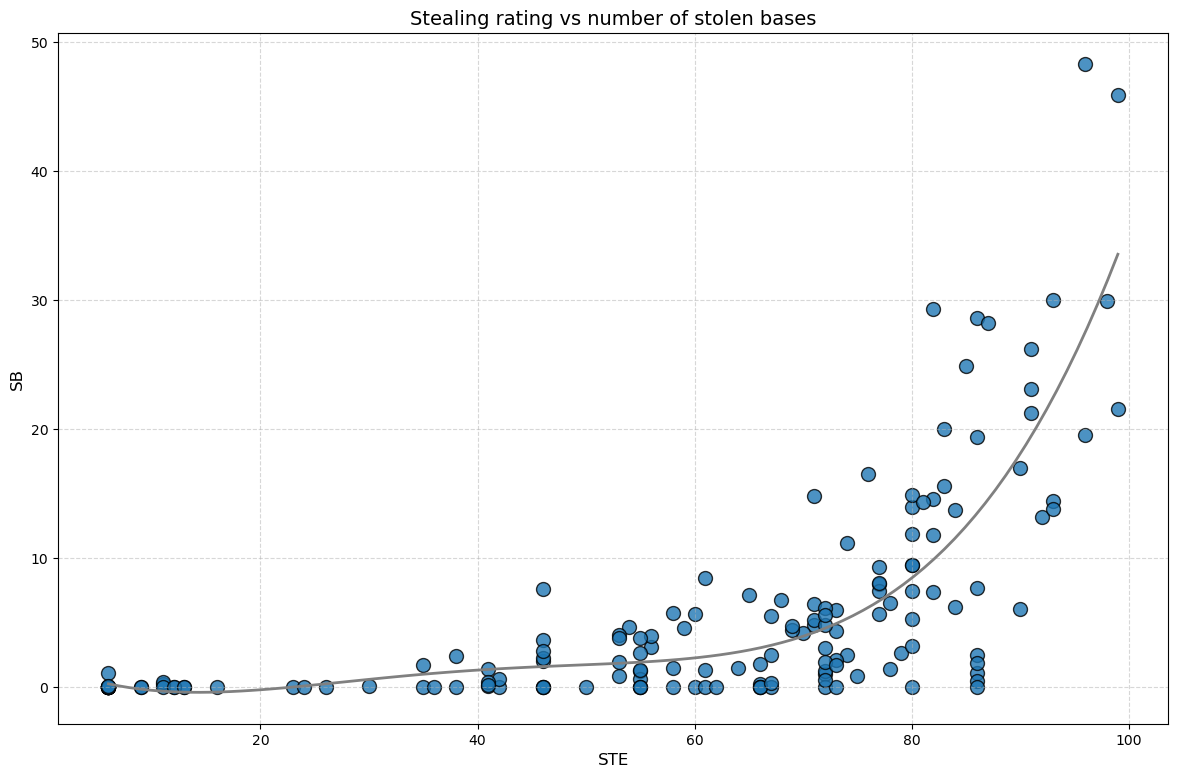

In [35]:
# Stolen bases

# Remove outliers using IQR method
Qd = df_batters_agg['SB'].astype(float).quantile(0.05)
Qu = df_batters_agg['SB'].astype(float).quantile(0.95)
IQR = Qu - Qd
lower_bound = Qd - 1.5 * IQR # not excluding anything but good to have it for completness
upper_bound = Qu + 1.5 * IQR

# Filter the data to remove outliers
series_sb = np.nan_to_num(df_batters_agg['SB'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)
series_ste = np.nan_to_num(df_batters_agg['STE'][(df_batters_agg['PA_WM'] > 200) & (df_batters_agg['SB'] >= lower_bound) & (df_batters_agg['SB'] <= upper_bound)].astype(float), nan=0.0)

plt.figure(figsize=(12, 8))
plt.scatter(series_ste, series_sb, s=100,
            marker='o', edgecolors='black', alpha=0.8)

# Calculate polynomial fit
coefficients = np.polyfit(series_ste, series_sb, 4)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(series_ste), max(series_ste), 100)
y_values = polynomial(x_values)


# Plot the trendline
plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

plt.xlabel('STE', fontsize=12)
plt.ylabel('SB', fontsize=12)
plt.title('Stealing rating vs number of stolen bases', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout(pad=1.5)

plt.show()


The relationship between the number of stolen bases and the stealing rating is superlinear in nature.

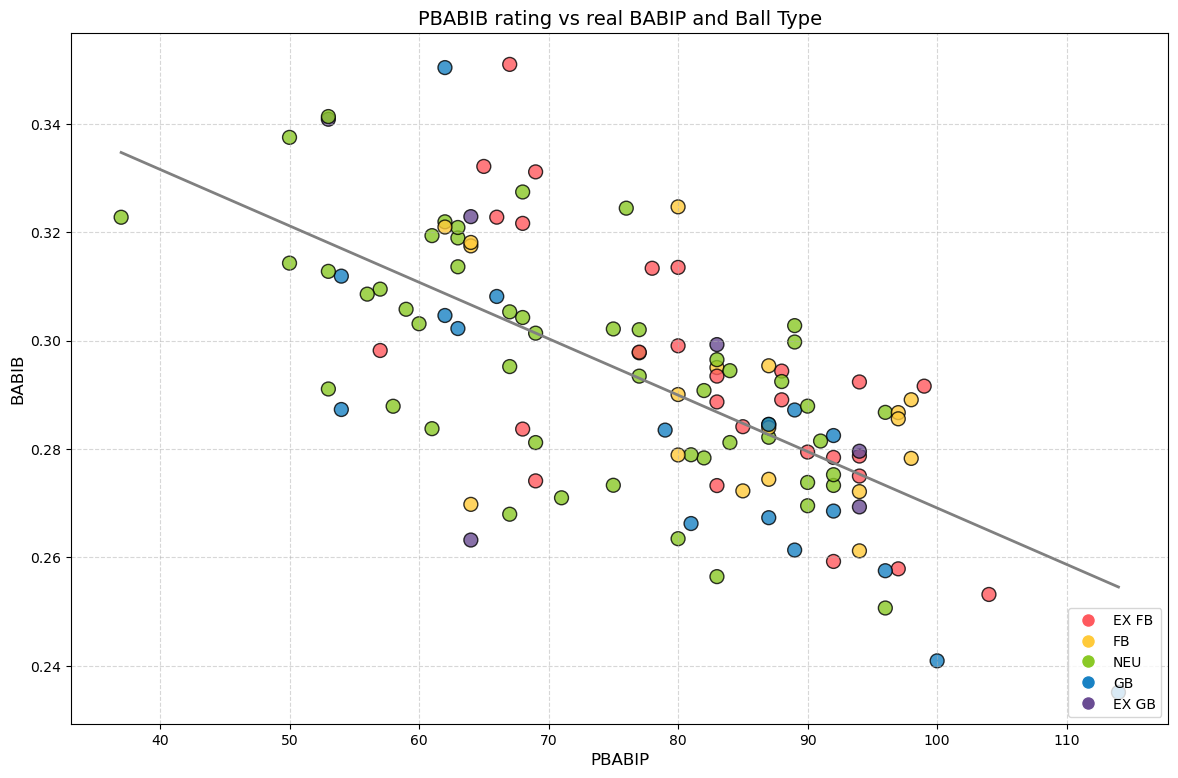

In [36]:
# Does ball type influence pitcher's BABIP?

# Set custom color palette for different 'G/F' categories
colors = {'EX FB': '#FF595E', 'FB': '#FFCA3A', 'NEU': '#8AC926', 'GB': '#1982C4', 'EX GB': '#6A4C93'}
chart_data = df_pitchers_agg[df_pitchers_agg['IP'] > 100]

plt.figure(figsize=(12, 8))

plt.scatter(chart_data['PBABIP'], chart_data['BABIP'], s=100, c=chart_data['G/F'].map(colors),
            marker='o', edgecolors='black', alpha=0.8)

# Fit linear regression
X = sm.add_constant(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0))
model = sm.OLS(np.nan_to_num(chart_data['BABIP'].astype(float), nan=0.0), X)
results = model.fit()
intercept, slope = results.params

x_values = np.linspace(min(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), max(np.nan_to_num(chart_data['PBABIP'].astype(float), nan=0.0)), 100)
y_values = intercept + slope * x_values

plt.plot(x_values, y_values, color='grey', linewidth=2, label='Trendline')

plt.xlabel('PBABIP', fontsize=12)
plt.ylabel('BABIB', fontsize=12)
plt.title('PBABIB rating vs real BABIP and Ball Type', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX FB'], markersize=10, label='EX FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['FB'], markersize=10, label='FB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['NEU'], markersize=10, label='NEU'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['GB'], markersize=10, label='GB'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['EX GB'], markersize=10, label='EX GB')]
plt.legend(handles=legend_elements, loc='lower right')

# NOTE: ADD OPACITY BASED ON PITCHED INNINGS

plt.tight_layout(pad=1.5)

# Save the plot as an image (optional)
# plt.savefig('scatter_plot_with_trendline.png', dpi=300)

plt.show()


There appears to be no discernible correlation between ball type and actual BABIP.

Check if there's a bias in the preferred handedness among starting pitchers.

In [186]:
df_pitchers_agg_team[(df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 100)].groupby('T')['Name'].count()

T
Left     197
Right    131
Name: Name, dtype: int64

In [188]:
df_pitchers_agg_team[(df_pitchers_agg_team['POS'] == 'SP') & (df_pitchers_agg_team['IP'] > 100)].groupby('T')['IP'].sum()

T
Left     28008.666667
Right    21956.000000
Name: IP, dtype: float64

There's more left handed starters.

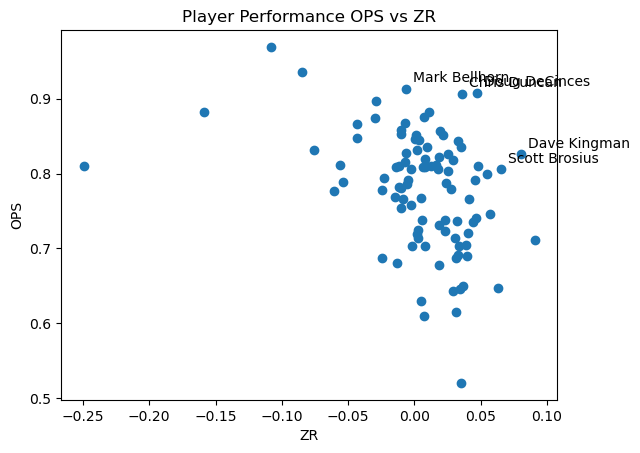

In [37]:
# Standardization
def standardize(column):
    mean = np.mean(column)
    std = np.std(column)
    standardized_column = (column - mean) / std
    return standardized_column
# Normalization
def min_max_normalize(column):
    min_val = min(column)
    max_val = max(column)
    normalized_column = [(val - min_val) / (max_val - min_val) for val in column]
    return normalized_column

data = df_batters_agg[(df_batters_agg['PA_WM'] > 500) & (df_batters_agg['Name'] != 'Jimmy Ryan')]

# Separate data into x and y coordinates
x = data['ZR']
y = data['OPS']
names = data['Name']


plt.scatter(x, y)

# Find the indices of the top 5 records in the right-top quadrant
top_records_indices = sorted(range(len(x)), key=lambda i: (standardize(x).iloc[i] + standardize(y).iloc[i]))[-5:]

# Add names to the top records
for index in top_records_indices:
    plt.annotate(names.iloc[index], (x.iloc[index], y.iloc[index]), xytext=(5, 5), textcoords='offset points')

plt.xlabel('ZR')
plt.ylabel('OPS')
plt.title('Player Performance OPS vs ZR')

plt.show()


The goal of this chart was to pinpoint players who excel both in ZR and OPS metrics.

## Modeling

### Team

Goal of the modeling is to answer following questions:

1. **Offense vs. Defense**: Is it more crucial for a team to rack up runs or to stifle the opponent's scoring opportunities?
2. **Positional Defensive Impact**: Based on individual position ratings, how many runs can potentially be saved? Innings played weighted average; sensitive to variations of player lineups across teams.
3. **Offensive Potential**: By improving team-wide metrics like BABIP, gap & homer power, plate discipline, and minimizing strikeouts, how many additional runs can be generated? This is gauged using a plate appearances weighted average. However, a caveat is the non-linearity of the game: elite hitters outpace their stats, so a mere average may obscure the distinctions between average, standout, and sub-par batters.

#### Winrate

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [40]:
# Is more important how many runs team score or prevent opponent to score - offense over defense
X = np.asarray(df_team_agg[['AVG_RA','AVG_R']], dtype=float)
y = np.asarray(df_team_agg['AVG_W'], dtype=float)

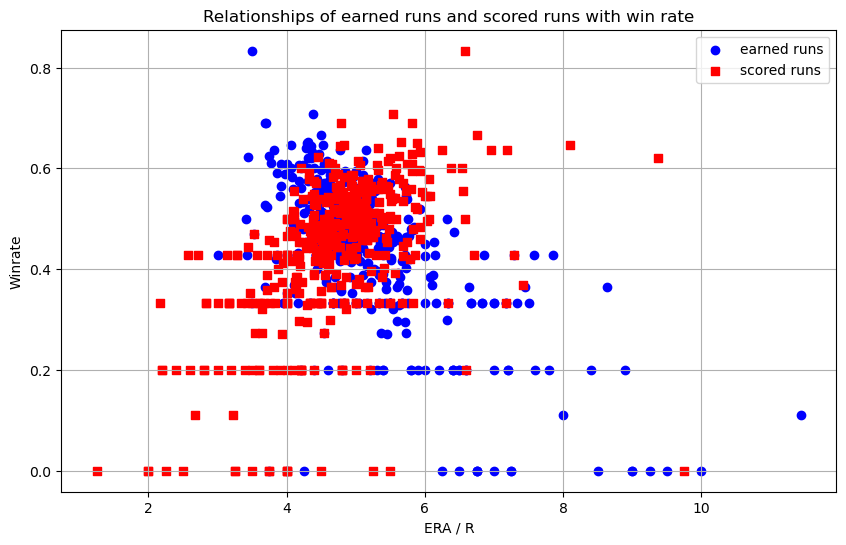

In [41]:
# Simple check that the relationship between scored, earned runs and winrate is as expected
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], y, color='blue', marker='o', label='earned runs')
plt.scatter(X[:, 1], y, color='red', marker='s', label='scored runs')
plt.title('Relationships of earned runs and scored runs with win rate')
plt.xlabel('ERA / R')
plt.ylabel('Winrate')
plt.legend()
plt.grid(True)
plt.show()


As the chart isn't that telling, modeling might provide clearer picture 

In [42]:
# adding weights as different teams have different number of played games (observations)
w = df_team_agg['W'] + df_team_agg['L']
w = np.asarray(w, dtype=float)
X = sm.add_constant(X)

# weighted least squares model
wregressor = sm.WLS(y, X, weights = w).fit()

print(wregressor.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.567
Model:                            WLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     280.8
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.08e-78
Time:                        15:03:58   Log-Likelihood:                 519.73
No. Observations:                 432   AIC:                            -1033.
Df Residuals:                     429   BIC:                            -1021.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5761      0.034     16.860      0.0

The result implies that winning teams put more importance on defense than offense.
However, given the high Jarque-Bera test values, the distribution may deviate from normality.

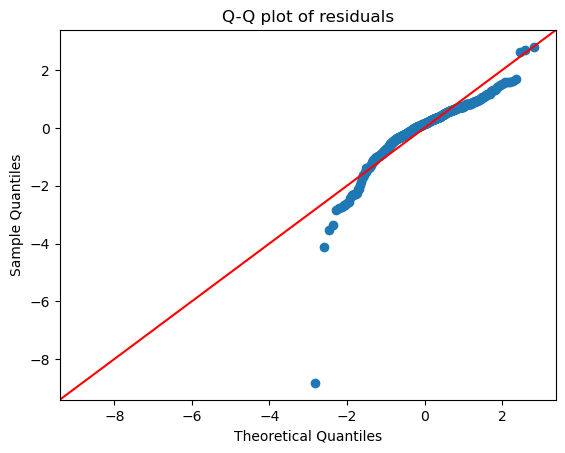

In [43]:
# check for normality of residuals based on JB test results
residuals = wregressor.resid

sm.qqplot(residuals, line='45', fit=True)  # '45' draws a 45-degree reference line
plt.title("Q-Q plot of residuals")
plt.show()

#### Pitching

Winrate can be further split into three main areas - defense (**pitching & fielding**) and **offense**.

In this section, the aim is to determine which pitching ratings or statistics impact the number of runs scored by opposing teams.

In [112]:
# Ratings 

df_team_agg_dropna = df_team_agg[['W','L','AVG_RA','AVG_STU','AVG_CON','AVG_PBABIP','AVG_HRR']].dropna().copy() # should add GB/FB ratio

df_team_agg_dropna = df_team_agg_dropna.astype('float64')

X = df_team_agg_dropna[['AVG_STU','AVG_CON','AVG_PBABIP','AVG_HRR']]
X = sm.add_constant(X)
y = df_team_agg_dropna['AVG_RA']
w = df_team_agg_dropna['W'] + df_team_agg_dropna['L']
w = np.asarray(w, dtype=float)

# weighted least squares model
wregressor = sm.WLS(y, X, weights = w).fit()

print(wregressor.summary())

                            WLS Regression Results                            
Dep. Variable:                 AVG_RA   R-squared:                       0.145
Model:                            WLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     18.11
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           9.50e-14
Time:                        17:27:10   Log-Likelihood:                -443.95
No. Observations:                 432   AIC:                             897.9
Df Residuals:                     427   BIC:                             918.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9814      1.008     12.881      0.0

The model's R-squared is notably low, coupled with issues of normality. There's no necessity to further adjust the model as the ratings don't seem to be that important.

In [46]:
# Stats 

df_team_agg_dropna = df_team_agg[['W','L','AVG_RA','AVG_HRA','AVG_KA','AVG_BBA']].dropna().copy() # should add GB/FB ratio

df_team_agg_dropna = df_team_agg_dropna.astype('float64')

X = df_team_agg_dropna[['AVG_HRA','AVG_KA','AVG_BBA']]
X = sm.add_constant(X)
y = df_team_agg_dropna['AVG_RA']
w = df_team_agg_dropna['W'] + df_team_agg_dropna['L']
w = np.asarray(w, dtype=float)

wregressor = sm.WLS(y, X, weights = w).fit()

print(wregressor.summary())

                            WLS Regression Results                            
Dep. Variable:                 AVG_RA   R-squared:                       0.422
Model:                            WLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     104.3
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.09e-50
Time:                        15:03:59   Log-Likelihood:                -359.28
No. Observations:                 432   AIC:                             726.6
Df Residuals:                     428   BIC:                             742.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4745      0.325      7.624      0.0

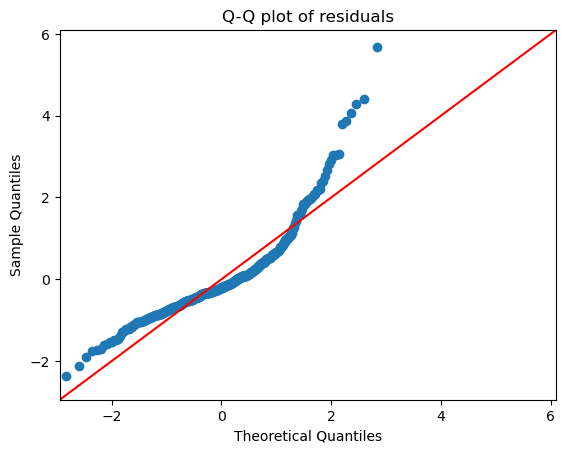

In [47]:
# check for normality of residuals
residuals = wregressor.resid

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q plot of residuals")
plt.show()

As anticipated, stats more effectively predict runs against. However, the extent of this accuracy is unexpected given the stats' reliance on ratings. This suggests some other factors at play e.g. the average ratings don't reflect well rotation assembled of diverse pitcher types, such as high-control contact pitchers versus those with high strikeout rates.

However, the linear model's assumption regarding the normality of residuals is violated. Thus, it might be more appropriate to explore a random forest model.

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf = RandomForestRegressor().fit(X.iloc[:,1:], y)

importances = rf.feature_importances_
for feature, importance in zip(X.iloc[:,1:].columns, importances):
    print(f"{feature}: {importance}")


y_pred = rf.predict(X.iloc[:,1:])
print("Mean Squared Error:", mean_squared_error(y, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y, y_pred))
print("R^2 Score:", r2_score(y, y_pred))

AVG_HRA: 0.2905493508833739
AVG_KA: 0.24575461158607637
AVG_BBA: 0.4636960375305498
Mean Squared Error: 0.10679286948096162
Mean Absolute Error: 0.21712825080581036
R^2 Score: 0.9017522257194399


R-squared is very high, possible overfitting.

In [50]:
# Cross-validation first. However sample is quite small so the differences might be quite significant.
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RandomForestRegressor(), X.iloc[:,1:], y, cv=3)

print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))

Cross-validation scores: [0.29208861 0.21301284 0.35414336]
Mean score: 0.2864149373320574


Cross-validation confirmed strong overfitting; yet, the random forest still outperformed the linear regression.

Next step - optimize hyperparameters for RF.

In [168]:
from sklearn.model_selection import train_test_split, GridSearchCV
def grid_search_cv(X, y, ts, cvn):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

    rf = RandomForestRegressor()

    # Define hyperparameters grid for tuning
    param_grid = {
        'n_estimators': [25, 50, 100, 150, 200], #5,10, 
        'max_depth': [3,4,5, 6,7], # none, 10 
        'min_samples_split': [ 10, 15, 20],
        'min_samples_leaf': [ 10, 15, 20],
        'bootstrap': [True] # False
        # overfitting: n_estimators up, max_depth down, min_samples_split up, bootstrap true, oob_score true, ccp_alpha?
        
    }

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=cvn, n_jobs=-1, verbose=2, scoring='r2')

    grid_search.fit(X_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)

    best_rf = grid_search.best_estimator_

    # Evaluate
    #full_score = best_rf.score(X, y)
    #print("Full R^2 Score:", full_score)

    train_score = best_rf.score(X_train, y_train)
    print("Train R^2 Score:", train_score)

    test_score = best_rf.score(X_test, y_test)
    print("Test R^2 Score:", test_score)

    return best_rf

In [169]:
best_rf = grid_search_cv(X.iloc[:,1:], y, 0.2, 3)

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
Train R^2 Score: 0.7244870222503168
Test R^2 Score: 0.6987064710517967


In [170]:
# Cross-validation
scores = cross_val_score(best_rf, X.iloc[:,1:], y, cv=3)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.60991388 0.577492   0.63886506]
Mean score: 0.6087569783782055


The grid search optimization method yielded only a marginal improvement in performance.

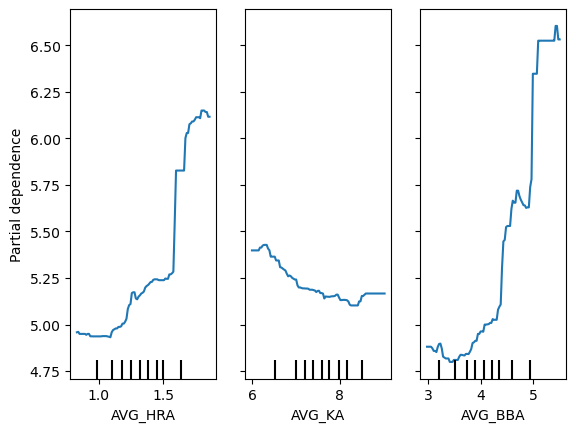

In [54]:
# How does each feature affect the output? 
# Partial Dependence Plots

from sklearn.inspection import PartialDependenceDisplay

display = PartialDependenceDisplay.from_estimator(best_rf, X.iloc[:,1:], list(range(0,X.iloc[:,1:].shape[1])))


As anticipated, the model shows a positive correlation between the predicted number of runs and home runs. A similar association is observed for BBs. An increase in strikeouts is inversely correlated with the number of runs, consistent with expectations.

#### Fielding

How many runs can be prevented based on each position's rating? - innings played weighted average of zone rating for each respective position.

In [171]:
#df_team_agg['AVG_RA'].fillna(0, inplace=True)
#df_team_agg['AVG_RA'].replace({None: 0}, inplace=True)

df_team_agg_dropna = df_team_agg[['W','L','AVG_RA','FRM_C','ZR_1B','ZR_2B','ZR_3B','ZR_SS','ZR_LF','ZR_CF','ZR_RF']].dropna().copy()

df_team_agg_dropna = df_team_agg_dropna.astype('float64')

X = df_team_agg_dropna[['FRM_C','ZR_1B','ZR_2B','ZR_3B','ZR_SS','ZR_LF','ZR_CF','ZR_RF']]
X = sm.add_constant(X)
y = df_team_agg_dropna['AVG_RA']
w = df_team_agg_dropna['W'] + df_team_agg_dropna['L']
w = np.asarray(w, dtype=float)

# wregressor = sm.WLS(y, X, weights = w).fit()
# print(wregressor.summary())

In [172]:
best_rf = grid_search_cv(X.iloc[:,1:], y, 0.2, 3)

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 25}
Train R^2 Score: 0.21186252068652078
Test R^2 Score: 0.1334663561555408


In [173]:
df_team_agg_dropna = df_team_agg[['W','L','AVG_RA','AVG_C','AVG_1B','AVG_2B','AVG_3B','AVG_SS','AVG_LF','AVG_CF','AVG_RF']].dropna().copy()

df_team_agg_dropna = df_team_agg_dropna.astype('float64')

X = df_team_agg_dropna[['AVG_C','AVG_1B','AVG_2B','AVG_3B','AVG_SS','AVG_LF','AVG_CF','AVG_RF']]
X = sm.add_constant(X)
y = df_team_agg_dropna['AVG_RA']

In [174]:
best_rf = grid_search_cv(X.iloc[:,1:], y, 0.2, 3)

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 15, 'n_estimators': 25}
Train R^2 Score: 0.22761579827547973
Test R^2 Score: 0.2509257538732247


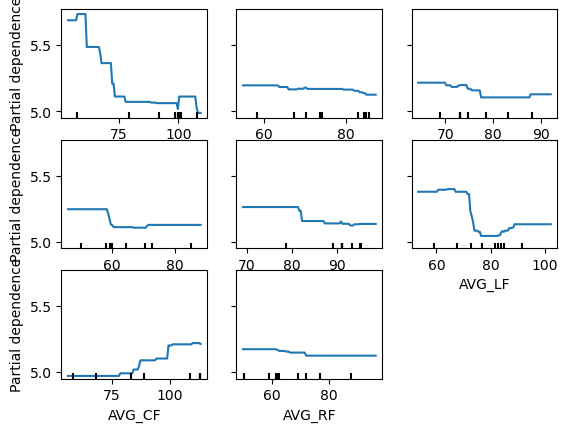

In [175]:
display = PartialDependenceDisplay.from_estimator(best_rf, X.iloc[:,1:], list(range(0,X.iloc[:,1:].shape[1])))

Zone statistics don't forecast fielding outcomes as effectively as ratings do. What's striking is that the central fielder, one of the pivotal defensive positions, exhibits an opposite relation to runs against than expected. This trend is probably driven by the lack of well rounded central fielders so many defensively rounded teams opt out for more offensive choices.

#### Batting

How many extra runs can be produced by enhancing team-wide statistics such as BABIP, gap & home run power, plate discipline, and by reducing strikeouts? This is assessed using averages weighted by plate appearances.

In [335]:
#df_team_agg['AVG_R'].fillna(0, inplace=True)
#df_team_agg['AVG_R'].replace({None: 0}, inplace=True)

df_team_agg_dropna = df_team_agg[['W','L','AVG_R','AVG_BABIP','AVG_GAP','AVG_POW','AVG_EYE','AVG_KS']].dropna().copy()
df_team_agg_dropna = df_team_agg_dropna.astype('float64')

X = df_team_agg_dropna[['AVG_BABIP','AVG_GAP','AVG_POW','AVG_EYE','AVG_KS']]
X = sm.add_constant(X)
y = df_team_agg_dropna['AVG_R']
w = df_team_agg_dropna['W'] + df_team_agg_dropna['L']
w = np.asarray(w, dtype=float)

# wregressor = sm.WLS(y, X, weights = w).fit()
# print(wregressor.summary())

In [336]:
best_rf = grid_search_cv(X.iloc[:,1:], y, 0.2, 3)

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 25}
Train R^2 Score: 0.2172860638251083
Test R^2 Score: 0.05905745497229142


In case of offensive productions, the rating averages across team's various batters don't work well.

In [337]:
df_team_agg_dropna = df_team_agg[['W','L','AVG_R','AVG_SINGLE','AVG_DOUBLE','AVG_HR', 'AVG_BB','AVG_SB']].dropna().copy()
df_team_agg_dropna = df_team_agg_dropna.astype('float64')

X = df_team_agg_dropna[['AVG_SINGLE','AVG_DOUBLE','AVG_HR', 'AVG_BB','AVG_SB']]
X = sm.add_constant(X)
y = df_team_agg_dropna['AVG_R']

In [339]:
best_rf = grid_search_cv(X.iloc[:,1:], y, 0.2, 3)
# overfitting hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 10}
batting_rf = best_rf #saving batting model for later use

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 50}
Train R^2 Score: 0.7229859185199499
Test R^2 Score: 0.6859205714399678


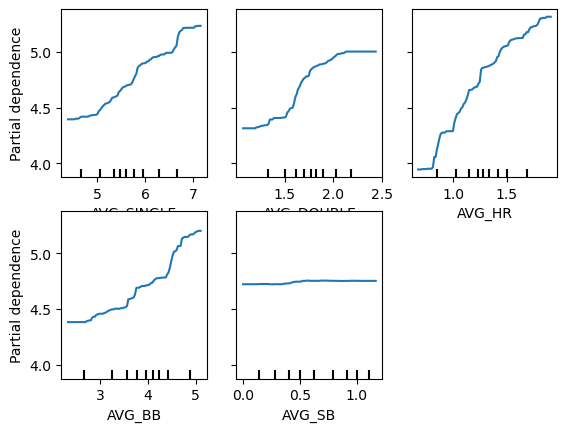

In [181]:
display = PartialDependenceDisplay.from_estimator(best_rf, X.iloc[:,1:], list(range(0,X.iloc[:,1:].shape[1])))

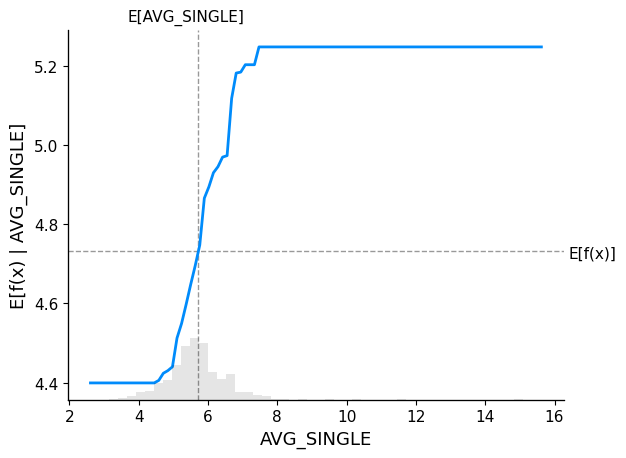

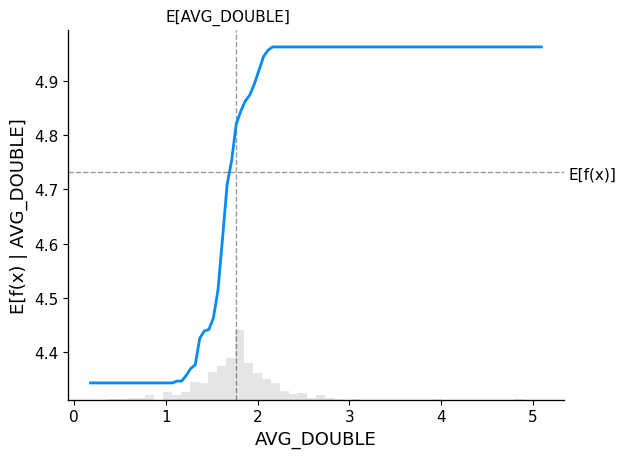

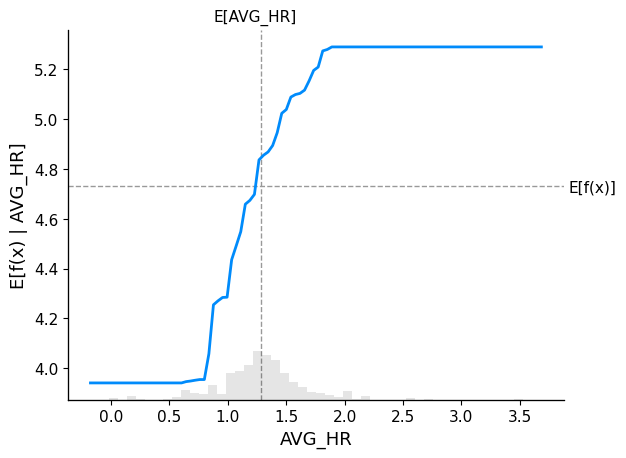

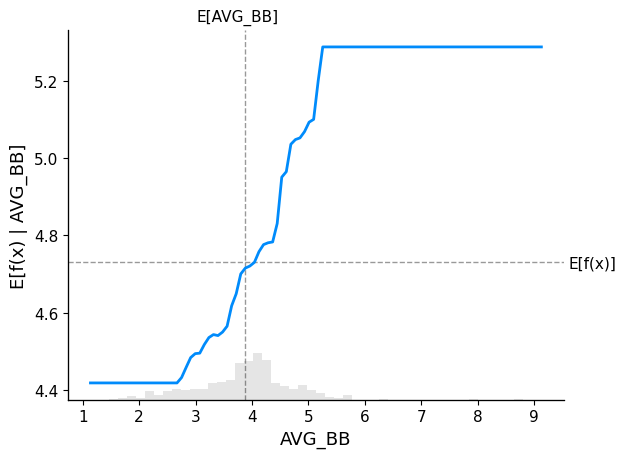

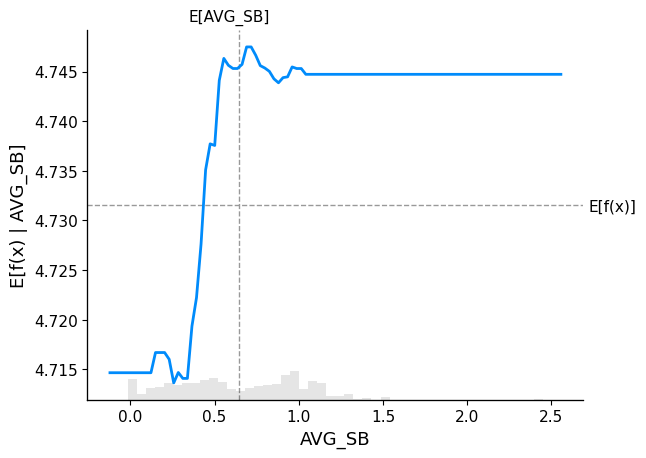

In [182]:
# same plot, just different method
# https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#Reading-SHAP-values-from-partial-dependence-plots

import shap

n_features = X.iloc[:,1:].shape[1]

# n_cols = 3 
# n_rows = (n_features // n_cols) + (n_features % n_cols > 0)

# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
# axes = axes.ravel()

for i in range(n_features):
    shap.plots.partial_dependence(
        i, best_rf.predict, X.iloc[:,1:], ice=False,
        model_expected_value=True, feature_expected_value=True, show=False #, ax=axes[i]
    )
    


#### Defense + Offense

In [189]:
df_team_agg_dropna = df_team_agg[['W','L','AVG_W','AVG_SINGLE','AVG_DOUBLE','AVG_HR', 'AVG_BB','AVG_SB','AVG_C','AVG_1B','AVG_2B','AVG_3B','AVG_SS','AVG_LF','AVG_CF','AVG_RF','AVG_HRA','AVG_KA','AVG_BBA']].dropna().copy()

df_team_agg_dropna = df_team_agg_dropna.astype('float64')

X = df_team_agg_dropna[['AVG_SINGLE','AVG_DOUBLE','AVG_HR', 'AVG_BB','AVG_SB','AVG_C','AVG_1B','AVG_2B','AVG_3B','AVG_SS','AVG_LF','AVG_CF','AVG_RF','AVG_HRA','AVG_KA','AVG_BBA']] # np.asarray(df_team_agg_dropna[['AVG_BABIP','AVG_GAP','AVG_POW','AVG_EYE','AVG_KS','FRM_C','ZR_1B','ZR_2B','ZR_3B','ZR_SS','ZR_LF','ZR_CF','ZR_RF','AVG_HRA','AVG_K','AVG_BB']], dtype=float)
y = df_team_agg_dropna['AVG_W']
w = df_team_agg_dropna['W'] + df_team_agg_dropna['L']
w = np.asarray(w, dtype=float)

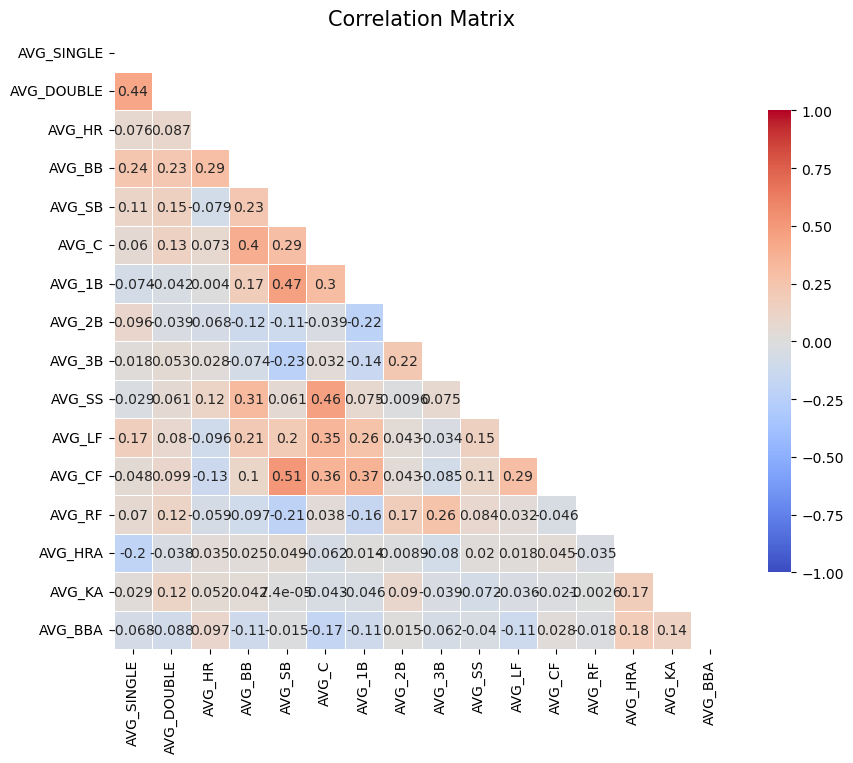

In [190]:
import seaborn as sns

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, vmin=-1,
            center=0, square=True, linewidths=.5, annot=True,
            cbar_kws={"shrink": 0.75})

plt.title('Correlation Matrix', fontsize=15)
plt.show()


In [195]:
best_rf = grid_search_cv(X, y, 0.2, 3)

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
Train R^2 Score: 0.6063143647510172
Test R^2 Score: 0.3480675215781748


The RF model is showing significant overfitting on the training data. Adjusting the parameters might improve its performance.

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
        n_estimators =  200, 
        max_depth= 3, 
        min_samples_split= 10,
        min_samples_leaf= 10,
        bootstrap= True ,
        max_features = 0.2
        #oob_score = True
    ).fit(X_train, y_train)

importances = rf.feature_importances_
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance}")

y_pred = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
print("Mean Squared Error Train:", mean_squared_error(y_train, y_pred))
#print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R^2 Score Train:", r2_score(y_train, y_pred))

print("Mean Squared Error Test:", mean_squared_error(y_test, y_pred_test))
print("R^2 Score Test:", r2_score(y_test, y_pred_test))


AVG_SINGLE: 0.14525371395415848
AVG_DOUBLE: 0.0775439303086668
AVG_HR: 0.09195054783403948
AVG_BB: 0.11028794044620764
AVG_SB: 0.023217308148210943
AVG_C: 0.08268164846473973
AVG_1B: 0.04670457024460699
AVG_2B: 0.0276879507415601
AVG_3B: 0.008339174894339324
AVG_SS: 0.020580231591723
AVG_LF: 0.037702340024048875
AVG_CF: 0.015326308388666467
AVG_RF: 0.019147941787081214
AVG_HRA: 0.12836665114575752
AVG_KA: 0.0400674238185055
AVG_BBA: 0.12514231820768795
Mean Squared Error Train: 0.012635567350835222
R^2 Score Train: 0.4026468584097366
Mean Squared Error Test: 0.010489834821763676
R^2 Score Test: 0.3627032177567756


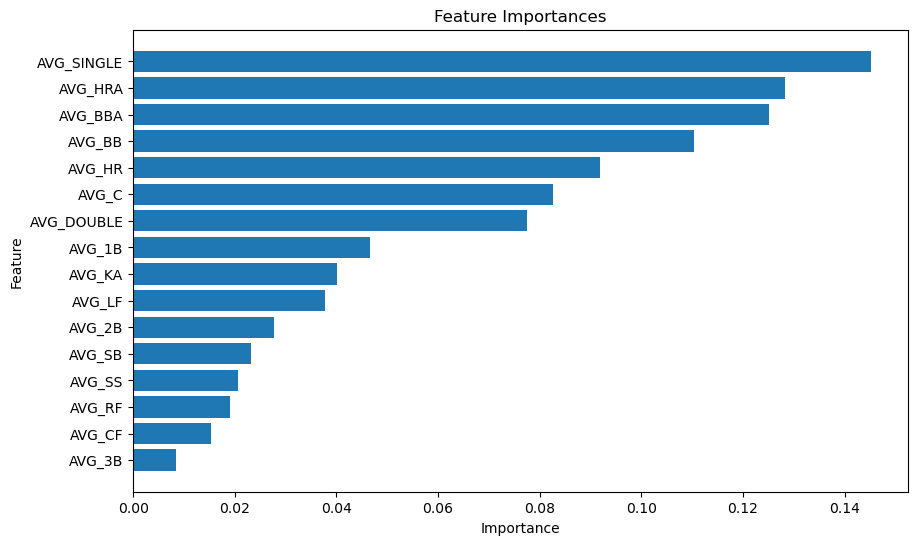

In [250]:
# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances
sorted_idx = importances.argsort()

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The most important features are related to pitching, specifically issuing a walk and giving up a home run. From batting attributes, getting on base features stand out, followed by fielding statistics where the catcher's skills rank highest. It's essential to note a problem: this model potentially reflects both the genuine impact of these stats on winning and the favored structure of successful teams.

In [251]:
def stepwise_rf(X, y, initial_n_features=None, criterion='squared_error'):
    if initial_n_features is None:
        initial_n_features = X.shape[1]
    
    # Initial model with all features
    model = RandomForestRegressor(criterion=criterion)
    model.fit(X, y)
    prev_mse = mean_squared_error(y, model.predict(X))
    
    features = list(X.columns)
    while len(features) > 1:
        # Get feature importances and identify the least important feature
        importances = model.feature_importances_
        least_important_idx = importances.argmin()
        least_important_feature = features[least_important_idx]

        # Remove the least important feature from the list
        features.pop(least_important_idx)
        X_reduced = X[features]

        # Fit the model with the reduced set of features
        model = RandomForestRegressor(criterion=criterion)
        model.fit(X_reduced, y)
        mse = mean_squared_error(y, model.predict(X_reduced))

        # If performance drops significantly or we've reached desired number of features, break
        if mse > prev_mse * 1.05 or len(features) <= initial_n_features:
            break

        prev_mse = mse

    return features



In [252]:
selected_features = stepwise_rf(X_train, y_train, initial_n_features=1)

selected_features

['AVG_SINGLE',
 'AVG_DOUBLE',
 'AVG_HR',
 'AVG_BB',
 'AVG_C',
 'AVG_1B',
 'AVG_3B',
 'AVG_SS',
 'AVG_HRA',
 'AVG_BBA']

The final step to try would be to remove non-essential features selected by stepwise 

In [254]:
rf2 = RandomForestRegressor(
        n_estimators =  200, 
        max_depth= 3, 
        min_samples_split= 10,
        min_samples_leaf= 10,
        bootstrap= True ,
        max_features = 0.2
        #oob_score = True
    ).fit(X_train.loc[:,selected_features], y_train)

y_pred = rf2.predict(X_train.loc[:,selected_features])
y_pred_test = rf2.predict(X_test.loc[:,selected_features])
print("Mean Squared Error Train:", mean_squared_error(y_train, y_pred))
#print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R^2 Score Train:", r2_score(y_train, y_pred))

print("Mean Squared Error Test:", mean_squared_error(y_test, y_pred_test))
print("R^2 Score Test:", r2_score(y_test, y_pred_test))


Mean Squared Error Train: 0.012748877409982451
R^2 Score Train: 0.397290065325103
Mean Squared Error Test: 0.010860214532983734
R^2 Score Test: 0.3402012620845096


In [266]:
importances = rf2.feature_importances_
for feature, importance in zip(X_train.loc[:,selected_features].columns, importances):
    print(f"{feature}: {importance}")

AVG_SINGLE: 0.17003667981019707
AVG_DOUBLE: 0.11906175430642751
AVG_HR: 0.12114301249548434
AVG_BB: 0.11720816504401982
AVG_C: 0.09000966983374908
AVG_1B: 0.061816013503826435
AVG_3B: 0.014084680555053236
AVG_SS: 0.03468887076316505
AVG_HRA: 0.13227837200564938
AVG_BBA: 0.13967278168242797


Stepwise selection removed the majority of defensive ratings (LF and CF appear to be logically flawed based on PDP), and notably, the pitcher's strikeouts stat was also excluded. However first base defensive rating remained in the model which seems to be irrelevant.

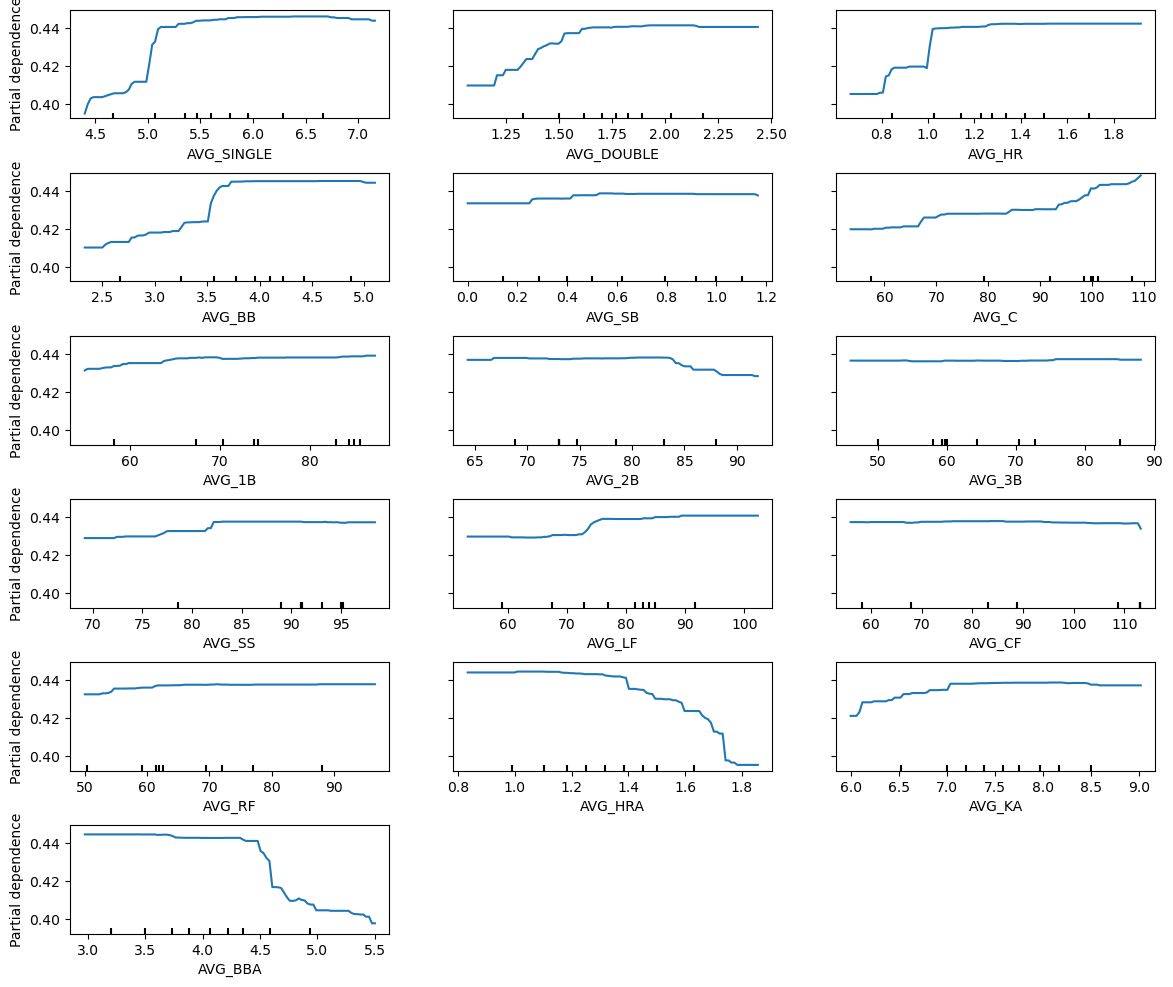

In [263]:
# Plot Partial Dependence Plots for the full RF
fig, ax = plt.subplots(figsize=(14, 12))
display = PartialDependenceDisplay.from_estimator(rf, X, list(range(0,X.shape[1])), ax=ax)

#plt.tight_layout(pad=8.0)
plt.subplots_adjust(hspace=0.5)

plt.show()


Based on the PDP there seems to be diminishing returns on most of the stats.

In **conclusion**, the team modeling has an issue: it combines different team strategies and only common strategies stand out. Winning teams focus on not allowing walks and home runs, getting on base, and having a good catcher. Given the low r-squared for pitching and fielding (considering the results of the last model, combining pitching and fielding doesn't appear to be worthwhile), the batting model seems to be the only one useful.

### Indiv. Pitching

Since each team has unique composition of fielders, it's challenging to assess the isolated impact of pitchers on runs against. The approach taken above, evaluating at the team level through three real outcomes, is the only feasible method. Therefore, this effort below aims to rank pitchers based on the previous models.

In [331]:
df_pitchers_agg_model = X_train.head(0)
df_pitchers_agg_model['Name'] = pd.NA

In [332]:
df_pitchers_agg_model[['AVG_HRA','AVG_BBA','AVG_KA','Name']] = df_pitchers_agg[(df_pitchers_agg['IP']>100) & (df_pitchers_agg['POS']=='SP')].loc[:,['HR','BB','K','Name']].rename(columns={'HR':'AVG_HRA','BB':'AVG_BBA','K':'AVG_KA'}).copy()
df_pitchers_agg_model.fillna(1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [333]:
df_pitchers_agg_model['pred'] = rf.predict(df_pitchers_agg_model.iloc[:, :-1])



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [334]:
df_pitchers_agg_model.iloc[:, -5:].sort_values(by='pred', ascending=False).head(15)

,AVG_HRA,AVG_KA,AVG_BBA,Name,pred
427,0.721068,8.132047,3.405045,Cole Hamels,0.311779
480,0.946436,7.603387,3.33911,Jim Clancy,0.311416
426,0.84467,7.351864,1.848267,Cliff Lee,0.311024
449,1.064789,9.050704,3.726761,Eric Erickson,0.310128
429,1.092816,8.352589,3.049949,Corey Kluber,0.310023
483,1.01509,6.242455,3.749616,Joe Genewich,0.309411
481,1.16386,7.198972,3.769055,Jim Deshaies,0.308879
422,1.169394,6.912416,3.508181,Charlie Lea,0.308850
439,0.722628,6.437956,3.941606,Dave Stewart,0.308735
573,0.940985,6.423792,4.504182,Vida Blue,0.308621


### Indiv. Batting

In [350]:
df_batters_agg[df_batters_agg['1B_other']>1]['1B_other'].mean()/df_team_agg['AVG_SINGLE'].mean()

16.990778267787114

In [ ]:
df_batters_agg_model = X_train.head(0)
df_batters_agg_model['Name'] = pd.NA

In [ ]:
df_batters_agg_model[['AVG_HRA','AVG_BBA','AVG_KA','Name']] = df_batters_agg[(df_batters_agg['IP']>100) & (df_batters_agg['POS']=='SP')].loc[:,['HR','BB','K','Name']].rename(columns={'HR':'AVG_HRA','BB':'AVG_BBA','K':'AVG_KA'}).copy()
df_batters_agg_model.fillna(1, inplace=True)

In [ ]:
df_batters_agg_model['pred'] = batting_rf.predict(df_batters_agg_model.iloc[:, :-1])
df_batters_agg_model.iloc[:, -5:].sort_values(by='pred', ascending=False).head(15)

In [77]:
# categorical predictors into numerical
df_batters_agg_model = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT'], drop_first=True)

# Dummy Variable Trap -> two or more dummy variables created by one-hot encoding are highly correlated (multi-collinear) -> drop_first=True

# outliers removal 
# 1) remove of players with not enough data collected based on the plate apperarances
df_batters_agg_model = df_batters_agg_model[df_batters_agg_model['PA_WM'] > 1000]

In [78]:
# size of sample
len(df_batters_agg_model)

75

In [79]:
predictors_batters = [
    'BABIP', 'CON', 'GAP', 'POW', 'EYE', "K's", 'BABIP vL', 'CON vL',
    'GAP vL', 'POW vL', 'EYE vL', 'K vL', 'BABIP vR', 'CON vR', 'GAP vR',
    'POW vR', 'EYE vR', 'K vR', 'BUN', 'BFH', 'BBT_Groundball',
    'BBT_Line Drive', 'BBT_Normal', 'GBT_Normal', 'GBT_Pull',
    'GBT_Spray', 'FBT_Pull', 'FBT_Spray'
]

#### Correlation

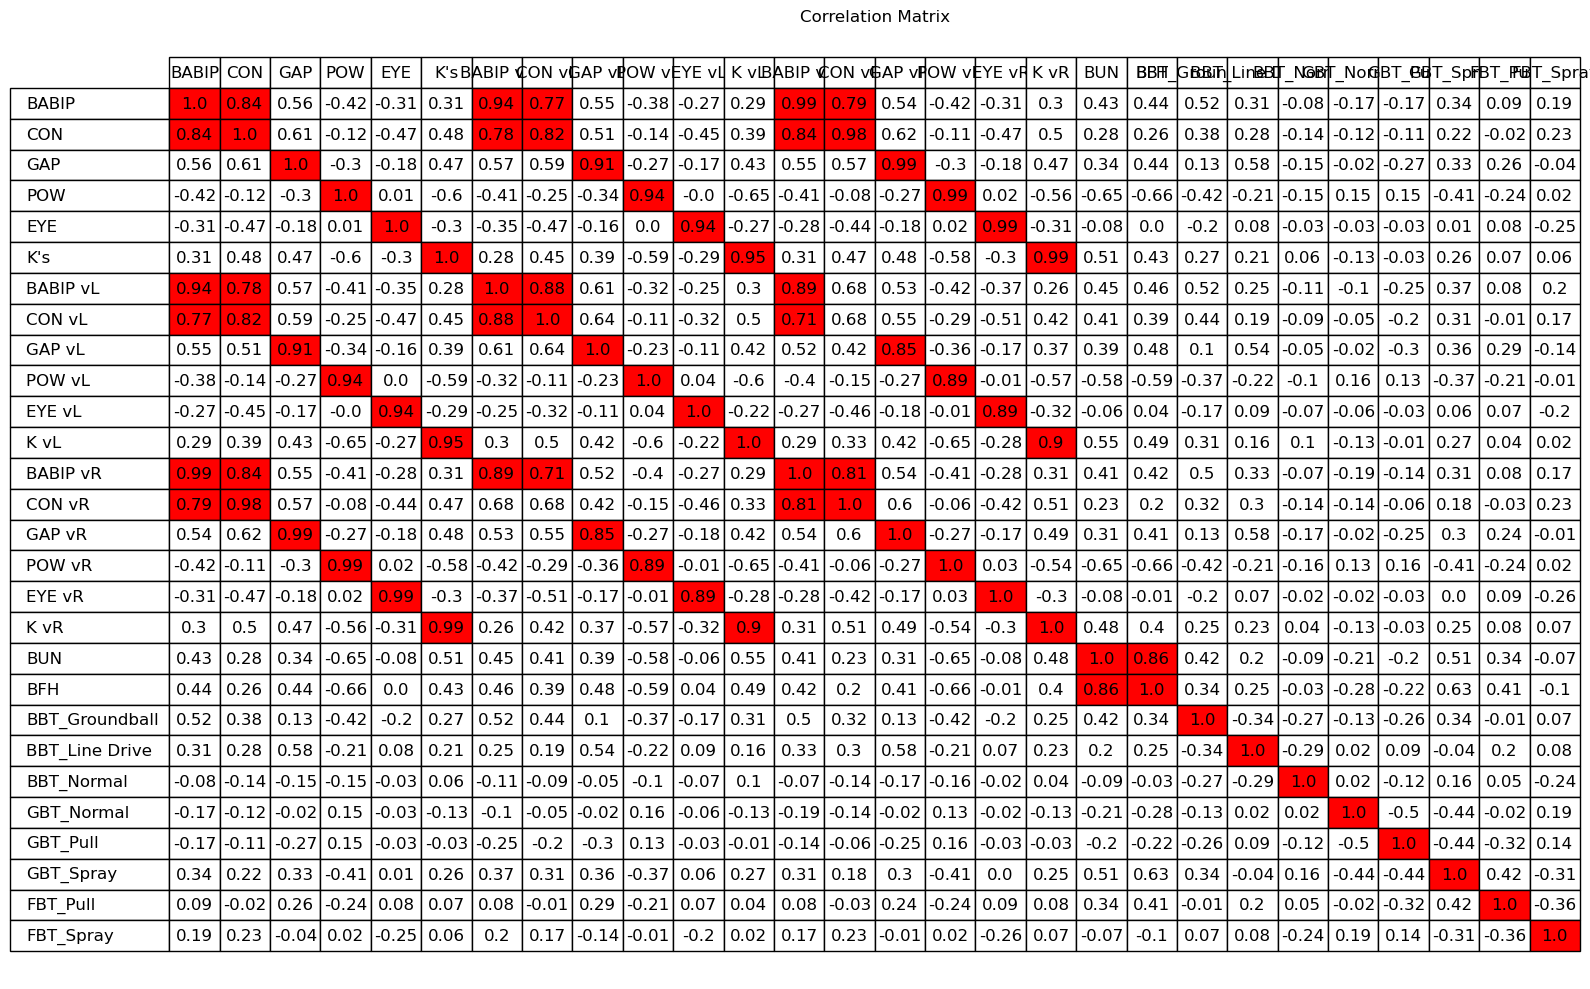

In [80]:
# Correlation matrix
correlation_matrix = df_batters_agg_model[predictors_batters].corr()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 10))

# Create a table plot
table = plt.table(cellText=correlation_matrix.round(2).values,
                  cellColours=np.where(np.abs(correlation_matrix.values) >= 0.7, 'red', 'white'),
                  rowLabels=correlation_matrix.index,
                  colLabels=correlation_matrix.columns,
                  cellLoc='center',
                  loc='center')

# Set table properties
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

# Hide axis
ax.axis('off')

# Set plot title
plt.title('Correlation Matrix')

# Adjust plot layout
plt.tight_layout()

# Show the plot
plt.show()

In [81]:
def get_correlated_pairs(correlation_matrix, threshold):
    pairs = []
    n = correlation_matrix.shape[0]

    for i in range(n):
        for j in range(i+1, n):
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) >= threshold:
                pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation)
                pairs.append(pair)

    return pairs

In [82]:
# Example usage
threshold = 0.8  # Correlation threshold
correlated_pairs = get_correlated_pairs(correlation_matrix, threshold)

# Print the correlated pairs
for pair in correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]}")

BABIP - CON: 0.8419058790271744
BABIP - BABIP vL: 0.9394415868229679
BABIP - BABIP vR: 0.9921143523437289
CON - CON vL: 0.8166572632996355
CON - BABIP vR: 0.8387893024485576
CON - CON vR: 0.9776140776689701
GAP - GAP vL: 0.9131356280127094
GAP - GAP vR: 0.9902732692262762
POW - POW vL: 0.9359226360201468
POW - POW vR: 0.9939832767099701
EYE - EYE vL: 0.9366039874442742
EYE - EYE vR: 0.9940143749145002
K's - K vL: 0.9465082583478311
K's - K vR: 0.9925257513687835
BABIP vL - CON vL: 0.8764552193929723
BABIP vL - BABIP vR: 0.8896347824483679
GAP vL - GAP vR: 0.848481939931017
POW vL - POW vR: 0.8920680677814193
EYE vL - EYE vR: 0.8933030788334352
K vL - K vR: 0.9009927836358848
BABIP vR - CON vR: 0.8120307884187175
BUN - BFH: 0.8637697635424558


In [83]:
# Removal of correlated predictors
for element in ['BABIP vL', 'BABIP vR','CON','GAP vL','GAP vR','EYE vL','EYE vR','CON vL','CON vR','POW vL','POW vR','K vL','K vR']:
    predictors_batters.remove(element)

<Axes: >

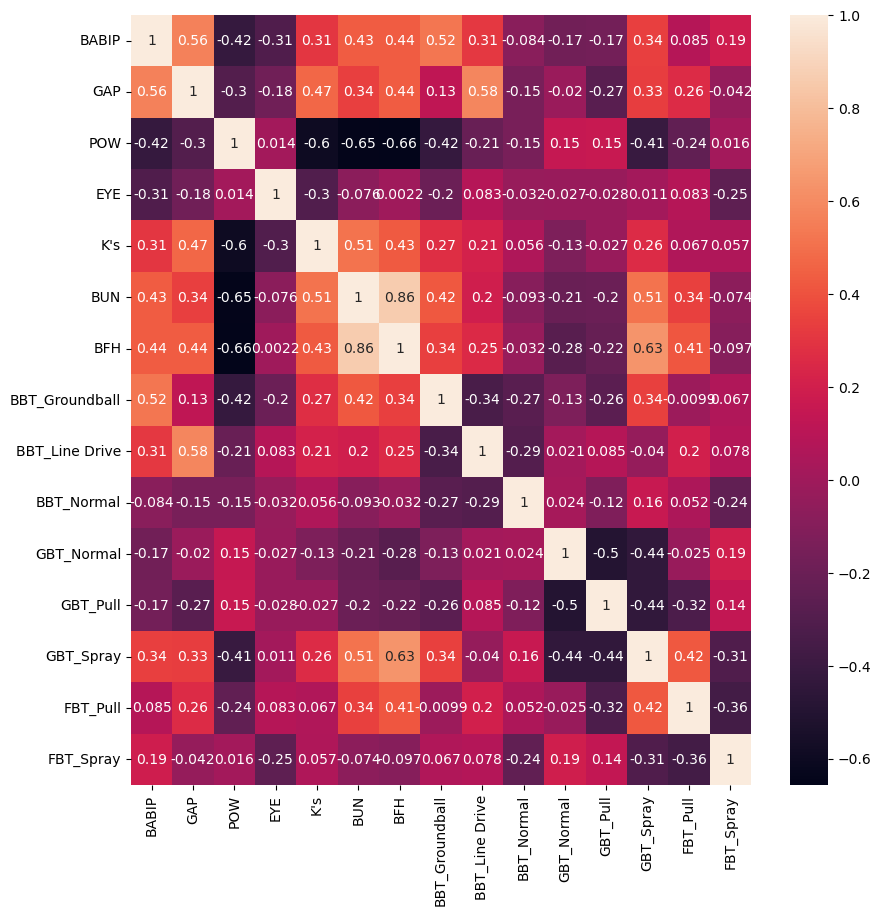

In [84]:
import seaborn as sns

plt.figure(figsize = (10, 10))
sns.heatmap(df_batters_agg_model[predictors_batters].corr(), annot = True)

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# the independent variables set
X = df_batters_agg_model[predictors_batters].astype(float).dropna()
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)
# note: VIF under 5 is fine

           feature        VIF
0            BABIP  60.783266
1              GAP  57.328210
2              POW  16.193459
3              EYE   9.717009
4              K's  25.779805
5              BUN  13.458196
6              BFH  13.888104
7   BBT_Groundball   9.667850
8   BBT_Line Drive   8.120480
9       BBT_Normal   4.225303
10      GBT_Normal   6.923696
11        GBT_Pull   7.276556
12       GBT_Spray   8.309259
13        FBT_Pull   1.922975
14       FBT_Spray   2.710223


In [86]:
# predictors and a target variable
X = np.asarray(df_batters_agg_model[predictors_batters].values, dtype=float)
y = np.asarray(df_batters_agg_model['OPS'].values, dtype=float)

# Handle missing values
X = np.nan_to_num(X, nan=0.0)  # Replace NaN values with 0
y = np.nan_to_num(y, nan=0.0)  # Replace NaN values with 0

# # Add a column of ones as the constant term to the predictor matrix
# X = np.append(arr=np.ones((X.shape[0], 1)), values=X, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
print("Size of train sample: " + str(len(X_train)))
print("Size of test sample: " + str(len(X_test)))

Size of train sample: 60
Size of test sample: 15


#### Backward OLS elimination

In [88]:
def backward_elimination(pred, dep, pn, significance_level=0.05):
    num_predictors = pred.shape[1]
    for i in range(num_predictors):
        regressor_OLS = sm.OLS(dep, pred).fit()
        max_pvalue = max(regressor_OLS.pvalues).astype(float)
        if max_pvalue > significance_level:
            for j in range(num_predictors - i):
                if regressor_OLS.pvalues[j].astype(float) == max_pvalue:
                    pred = np.delete(pred, j, 1)
                    del pn[j-1] # -1 because there's an extra constant
    regressor_OLS.summary()
    return pred, pn

In [89]:
pred_names = predictors_batters.copy()

# Addition of intercept (a column of ones)
X_trn_ols = sm.add_constant(X_train)
X_tst_ols = sm.add_constant(X_test)

# Perform backward elimination
XPN = backward_elimination(X_trn_ols, y_train, pred_names, 0.1)
X_trn_ols = XPN[0]
pred_names = XPN[1]

# Fit the final model
regressor = sm.OLS(y_train, X_trn_ols).fit()

# Print the summary of the final model
print(regressor.summary())
print("Predictor names:", pred_names, sep="\n")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     38.25
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.45e-17
Time:                        15:10:22   Log-Likelihood:                 117.52
No. Observations:                  60   AIC:                            -221.0
Df Residuals:                      53   BIC:                            -206.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2596      0.050      5.154      0.0

In [90]:
# notes: Kurtosis: 3.282 -> distribution is too peaked

In [91]:
# Create a dictionary to map index labels to positions
position_dict = {label: position for position, label in enumerate(predictors_batters)}

# Retrieve positions of columns from the dictionary
column_positions = [position_dict[column] + 1 for column in pred_names]
column_positions = np.insert(column_positions, 0, 0)

# Apply results of backward elimination to test sample
X_test_be = X_tst_ols[:, column_positions]

In [92]:
from sklearn.metrics import mean_squared_log_error, r2_score

# Make predictions on the testing data
y_pred = regressor.predict(X_test_be)

RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print ("The R2 score is {:.2f}%".format(train_r2*100))

The rmse score is 0.02161
The R2 score is 74.80%


In [93]:
# Sample is extremely small -> cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Cross-validation
scores = cross_val_score(LinearRegression(), X_trn_ols, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [0.6838948  0.79762913 0.67395701 0.5226754  0.88800306]
Mean score: 0.713231879665017


#### Lasso

In [94]:
from sklearn.linear_model import Lasso

pred_names = predictors_batters.copy()

# Lasso regression
lasso = Lasso(alpha=0.01)  
            # Set the regularization parameter alpha
            # any real-valued number between zero and infinity; the larger the value, the more aggressive the penalization is.
lasso.fit(X_train, y_train)
lasso_predictions = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

# Print the coefficients
print("Lasso Coefficients:")
for feature, coef in zip(pred_names, lasso.coef_):
    if coef != 0.00000000: print(f"{feature}: {coef:.4f}") # Print out only non-zero coefs

# Print the mean squared errors
print(f"\nLasso MSE: {lasso_mse:.4f}")

train_r2 = r2_score(y_true=y_test, y_pred=lasso_predictions)
print ("The R2 score is {:.2f}%".format(train_r2*100))


# Cross-validation
scores = cross_val_score(lasso, X_train, y_train, cv=5) 

# Print the cross-validation scores
print("\nCross-validation scores:", scores)
print("Mean score:", np.mean(scores))


## Ridge regression shrinks all regression coefficients towards zero

Lasso Coefficients:
BABIP: 0.0024
GAP: 0.0010
POW: 0.0029
EYE: 0.0009
K's: 0.0008
BUN: 0.0000
BFH: 0.0001

Lasso MSE: 0.0014
The R2 score is 77.30%

Cross-validation scores: [0.63931498 0.79737869 0.64975232 0.40636986 0.90241618]
Mean score: 0.6790464037046743


#### XGBoost

In [95]:
import xgboost as xgb

# XGBRFRegressor (random forest)
xgb_model = xgb.XGBRFRegressor(objective ='reg:squarederror') # , colsample_bytree=0.2, learning_rate = 0.2, max_depth=5, alpha=5, n_estimators=40

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred) )
print("The rmse score is %.5f" % RMSLE )

train_r2 = r2_score(y_true=y_test, y_pred=y_pred)
print ("The R2 score is {:.2f}%".format(train_r2*100))

The rmse score is 0.02202
The R2 score is 74.38%


In [96]:
# Cross-validation
scores = cross_val_score(xgb_model, X_train, y_train, cv=5) 

# Print the cross-validation scores
print("\nCross-validation scores:", scores)
print("Mean score:", np.mean(scores))


Cross-validation scores: [ 0.44041048  0.06474248  0.44256334 -0.12180198  0.5495616 ]
Mean score: 0.27509518327316423


In [97]:
# # XGB Cross-validation 2
# data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
# params = {'objective':'reg:squarederror'}
# xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, metrics = 'logloss',seed=42) 

# xgb_cv

In [98]:
# Best model search
# from sklearn.model_selection import GridSearchCV

# best_xgb = GridSearchCV(
#     xgb_model, param_grid={}, cv=10, verbose=0, n_jobs=-1)

# scores = cross_val_score(best_xgb, X_train, y_train, scoring='r2')
# scores

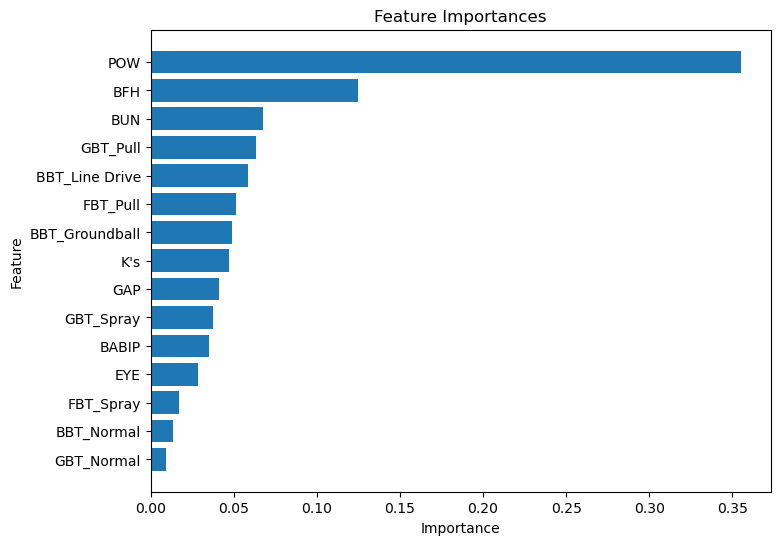

In [99]:
# Get feature importances
importance = xgb_model.feature_importances_

# Create a DataFrame to hold the feature names and importances
feature_importances = pd.DataFrame({'Feature': pred_names, 'Importance': importance})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

#### Prediction

In [100]:
# Predict OPS
# categorical predictors into numerical
df_batters_agg = pd.get_dummies(df_batters_agg, columns=['BBT','GBT','FBT'], drop_first=True)

df_batters_agg['ops_pred'] = lasso.predict(df_batters_agg[predictors_batters])
df_batters_agg.sort_values('ops_pred', ascending = False)

X has feature names, but Lasso was fitted without feature names


,POS,Name,Lev,HT,B,T,OVR,BABIP,CON,GAP,POW,EYE,K's,BABIP vL,CON vL,GAP vL,POW vL,EYE vL,K vL,BABIP vR,CON vR,GAP vR,POW vR,EYE vR,K vR,BUN,BFH,C ABI,C ARM,IF RNG,IF ERR,IF ARM,TDP,OF RNG,OF ERR,OF ARM,DEF,P,C,1B,2B,3B,SS,LF,CF,RF,SPE,STE,RUN,G,GS,PA,AB,H,1B_other,2B_other,3B_other,HR,RBI,R,BB,BB%,IBB,HP,SH,SF,CI,SO,SO%,GIDP,EBH,TB,AVG,OBP,SLG,RC,RC/27,ISO,wOBA,OPS,OPS+,BABIP_other,WPA,wRC,wRC+,wRAA,WAR,PI/PA,SB,CS,SB%,BatR,wSB,UBR,BsR,G_other,GS_other,TC,A,PO,E,DP,TP,PCT,RNG,ZR,EFF,SBA,RTO,RTO%,IP,PB,CER,CERA,BIZ-R%,BIZ-R,BIZ-Rm,BIZ-L%,BIZ-L,BIZ-Lm,BIZ-E%,BIZ-E,BIZ-Em,BIZ-U%,BIZ-U,BIZ-Um,BIZ-Z%,BIZ-Z,BIZ-Zm,BIZ-I,FRM,ARM,BF%,PA_WM,IP_WM,BBT_Groundball,BBT_Line Drive,BBT_Normal,GBT_Normal,GBT_Pull,GBT_Spray,FBT_Pull,FBT_Spray,ops_pred
315,DH,Andre Ethier,TRN,"6' 2""",Left,Left,64,83,93,87,79,63,65,67,61,61,56,45,44,89,103,96,87,68,72,5,3,0,0,3,7,5,5,46,54,76,0,0,0,0,0,0,0,57,0,52,38,41,55,179.829002,136.660953,55.875278,528.222656,163.123804,89.259805,37.290737,3.216677,33.356585,102.281967,98.545121,65.870137,11.081013,1.733897,1.500717,0.0,4.041773,0.364716,98.443479,16.805234,18.301578,73.863999,306.91765,0.306668,0.382697,0.586425,10.928786,8.805345,0.279687,0.410695,0.969127,145.354677,0.319803,2.681441,105.707908,146.957127,35.308713,3.863002,3.744148,0.352758,2.236129,3.285078,35.308713,-0.41195,-0.986527,-1.395488,25.996492,7.079082,18.146126,0.436464,17.255261,0.454401,0.0,0.0,1.07931,1.652489,-0.108088,0.58154,0.0,0.0,0.0,7.469432,0.0,0.0,0.0,52.589087,3.149886,3.057634,13.808463,0.702651,0.36952,3.730512,0.589386,0.128127,3.730512,0.312631,0.0205,2.115813,0.466897,0.107627,1.174673,0.0,0.049867,100.0,1796,235.1,0,1,0,0,1,0,0,1,0.900756
325,LF,Andre Ethier,TRN,"6' 2""",Left,Left,64,83,93,87,79,63,65,67,61,61,56,45,44,89,103,96,87,68,72,5,3,0,0,3,7,5,5,46,54,76,57,0,0,0,0,0,0,57,0,52,38,41,55,190.759662,125.544203,45.322148,548.023101,178.409596,93.38072,30.297645,8.174145,46.557086,128.565082,110.617503,46.823634,6.695302,0.0,0.0,0.0,5.153265,0.0,78.45402,14.754362,2.576633,85.028876,364.726788,0.315396,0.355785,0.645034,11.174497,10.003356,0.33004,0.417886,1.000819,150.557047,0.303262,7.526433,114.438028,151.38255,48.138605,4.522434,3.529597,6.663705,0.0,50.33557,48.138605,2.407819,-8.12972,-5.721901,162.9498,125.544203,249.311417,9.418036,237.316748,2.576633,0.0,0.0,0.10936,2.037718,-0.058813,0.954859,0.0,0.0,0.0,81.087248,0.0,0.0,0.0,98.187919,1.65873,1.616135,60.189262,0.342804,0.195771,44.281879,0.199048,0.113858,6.481208,0.319869,0.019659,9.395973,0.351405,0.013106,0.346081,0.0,0.001884,100.0,149,271.0,0,1,0,0,1,0,0,1,0.900756
406,RF,Andre Ethier,TRN,"6' 2""",Left,Left,64,83,93,87,79,63,65,67,61,61,56,45,44,89,103,96,87,68,72,5,3,0,0,3,7,5,5,46,54,76,52,0,0,0,0,0,0,57,0,52,38,41,55,164.668026,135.619013,51.191254,532.832914,170.022667,100.97616,36.969918,2.53551,29.54108,99.667399,100.610527,57.58204,9.594198,3.707585,2.39199,0.0,7.090543,0.102514,104.020822,17.694956,13.384894,69.046507,300.686843,0.31347,0.378873,0.556353,10.119475,8.961283,0.242844,0.397117,0.935182,138.069096,0.341518,4.145251,101.584409,138.494752,31.328921,3.491281,3.715248,0.164022,2.53551,0.845481,31.328921,-0.756552,-0.584329,-1.357284,84.174137,73.751894,169.069288,4.404679,161.209891,3.454717,0.830362,0.0,0.157616,1.98412,-0.084494,0.779706,0.0,0.0,0.0,54.979213,0.0,0.0,0.0,73.146414,3.259727,3.113473,38.820175,0.569775,0.352463,19.388309,0.469623,0.161752,13.818222,0.40382,0.08586,9.969446,0.360782,0.067208,0.789538,0.0,0.020717,99.030612,3430,3634.3,0,1,0,0,1,0,0,1,0.900756
138,3B,Doug DeCinces,TRN,"6' 2""",Right,Right,65,65,85,91,82,72,80,64,82,80,73,78,84,65,86,94,85,70,79,6,1,0,0,65,64,78,65,2,8,9,69,0,0,0,0,69,0,0,0,0,24,30,5,135.255295,130.994608,75.545327,528.738862,159.636576,92.403582,35.855286,2.452886,28.924822,107.628467,89.393934,60.706127,10.023339,2.40593,2.938096,0.0,7.448097,0.168818,86.963408,14.339654,15.942639,67.232994,287.172101,0.298903,0.368705,0.539098,13.608516,7.699057,0.240188,0.38639,0.907869,130.304195,0

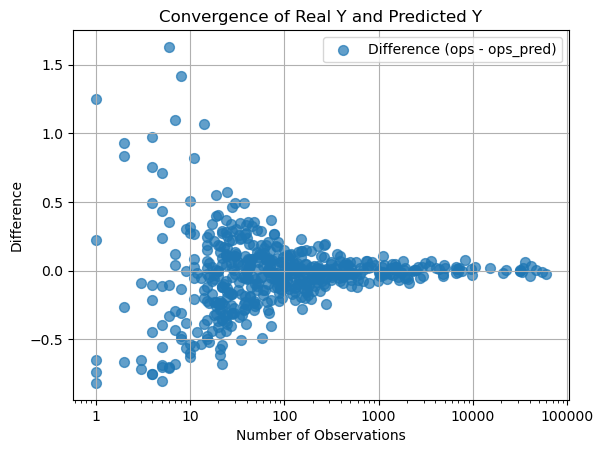

In [101]:
from matplotlib.ticker import ScalarFormatter

def plot_convergence(observations, ops, ops_pred):
    differences = np.array(ops) - np.array(ops_pred)

    plt.scatter(observations, differences, s=50, alpha=0.7, label='Difference (ops - ops_pred)')

    plt.xlabel('Number of Observations')
    plt.ylabel('Difference')
    plt.title('Convergence of Real Y and Predicted Y')
    plt.legend()
    plt.grid(True)
    plt.xscale('log')  # Set logarithmic scale for the x-axis
    #plt.xlim(1, 10000)  # Set x-axis limits
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    plt.show()


plot_convergence( df_batters_agg['PA_WM'], df_batters_agg['OPS'], df_batters_agg['ops_pred'])


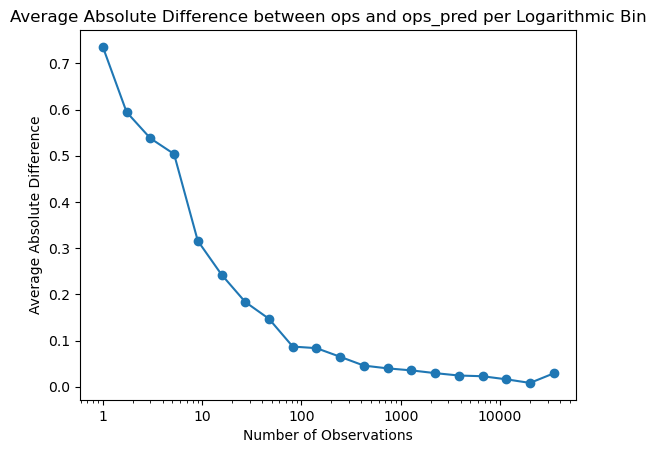

In [102]:
observations = df_batters_agg['PA_WM']
ops = df_batters_agg['OPS']
ops_pred = df_batters_agg['ops_pred']

# Calculate the absolute differences between ops and ops_pred
differences = np.abs(np.array(ops) - np.array(ops_pred))

# Calculate the logarithmic bins
log_bins = np.logspace(np.log10(1), np.log10(max(observations)),num=21)

# Calculate the bin indices for each observation
bin_indices = np.digitize(observations, log_bins)

# Calculate the average absolute differences for each bin
bin_averages = [np.mean(differences[bin_indices == i]) for i in range(1, len(log_bins))]


fig, ax = plt.subplots()
ax.plot(log_bins[:-1], bin_averages, 'o-')

ax.set_xscale('log')
ax.set_xlabel('Number of Observations')
ax.set_ylabel('Average Absolute Difference')
ax.set_title('Average Absolute Difference between ops and ops_pred per Logarithmic Bin')

# Set full number format for x-axis ticks
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.show()